In [1]:
import sys
import os
current_dir = os.getcwd()  #use to import the defined functions
parent_dir = os.path.dirname(current_dir) 
sys.path.append(parent_dir)  

"""
incase the above code does not work, you can use the absolute path instead
sys.path.append(r".\")
"""

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 

In [2]:
from data.image_data import DatasetLoader
from utils.basic_utils import setup_seed, sample_noise
from utils.training_utils import train_WGR_image
from models.generator import generator_fnn, generator_cnn 
from models.discriminator import discriminator_fnn, discriminator_cnn
from utils.plot_utils import visualize_mnist_digits, visualize_digits, convert_generated_to_mnist_range 

In [3]:
import argparse

if 'ipykernel_launcher.py' in sys.argv[0]:  #if not work in jupyter, you can delete this part
    import sys
    sys.argv = [sys.argv[0]] 


parser = argparse.ArgumentParser(description='Implementation of WGR for MNIST dataset')

parser.add_argument('--Xdim', default=784, type=int, help='dimensionality of X')
parser.add_argument('--Ydim', default=144, type=int, help='dimensionality of Y')

parser.add_argument('--noise_dim', default=100, type=int, help='dimensionality of noise vector')
parser.add_argument('--noise_dist', default='gaussian', type=str, help='distribution of noise vector')

parser.add_argument('--train', default=10000, type=int, help='size of train dataset')
parser.add_argument('--val', default=1000, type=int, help='size of validation dataset')
parser.add_argument('--test', default=1000, type=int, help='size of test dataset')

parser.add_argument('--train_batch', default=100, type=int, metavar='BS', help='batch size while training')
parser.add_argument('--val_batch', default=100, type=int, metavar='BS', help='batch size while validation')
parser.add_argument('--test_batch', default=100, type=int, metavar='BS', help='batch size while testing')

parser.add_argument('--device', default='cpu', type=str, help='device')
args = parser.parse_args()

print(args)


Namespace(Xdim=784, Ydim=144, noise_dim=100, noise_dist='gaussian', train=10000, val=1000, test=1000, train_batch=100, val_batch=100, test_batch=100, device='cpu')


In [4]:
device = 'cpu'

# Initialize dataset loader
loader = DatasetLoader()

# Load subset of MNIST dataset
train_loader, val_loader, test_loader, classes = loader.load_mnist(
    train_size=args.train, val_size=args.val, test_size=args.test, 
    train_batch=args.train_batch, val_batch=args.val_batch, test_batch=args.test_batch,
    mask_size=12, mask_position=(7, 7)
)

Applied 12x12 mask at position (7, 7)


In [5]:
# take examples for visualization
eg_examples = enumerate(test_loader) 


In [7]:
batch_idx, (eg_x, eg_y, eg_label) = next(eg_examples) # take samples from the first batch
recon_x = eg_x.clone() # the one used in the training process for visulation
global eg_x, eg_y,  recon_x

In [8]:
# sample 2 samples from each class
num_classes = eg_label.max().item() + 1   
num_samples_per_class = 2

selected_indices = []

for c in range(num_classes):
    class_indices = (eg_label == c).nonzero(as_tuple=True)[0]
    selected = class_indices[:num_samples_per_class]  
    selected_indices.append(selected)
    
selected_indices = torch.cat(selected_indices)
selected_labels = eg_label[selected_indices]

print("Selected indices:", selected_indices)
print("Selected labels:", selected_labels)

Selected indices: tensor([ 1, 26,  7, 35,  6, 19, 12, 42,  3,  9,  2, 20,  0, 23, 11, 14, 10, 28,
         4,  5])
Selected labels: tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])


In [9]:
recon_x[selected_indices, :, 7:19, 7:19] = eg_y[selected_indices]

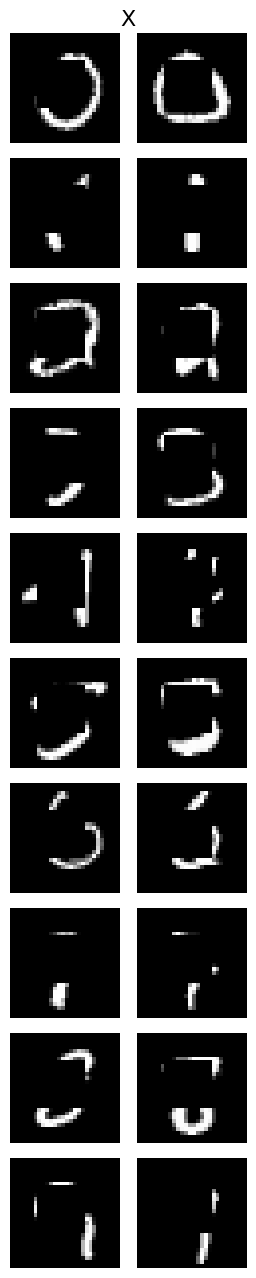

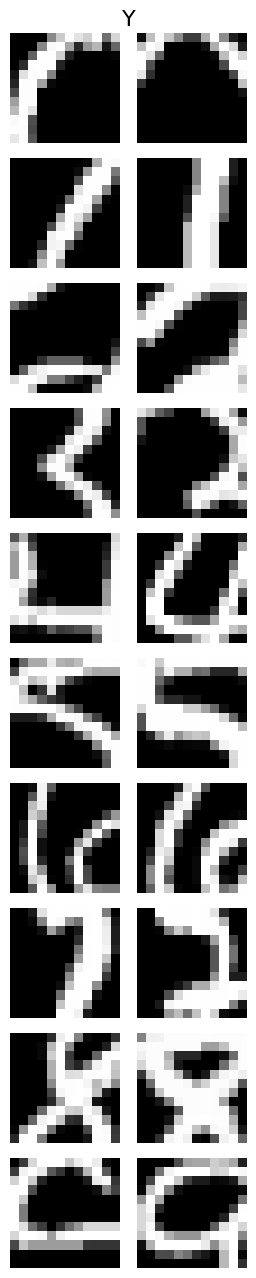

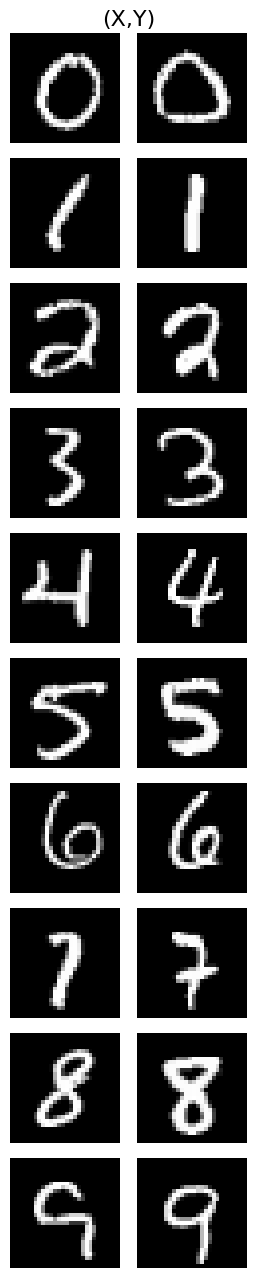

In [10]:
#plot the X, Y, and XY
visualize_digits( images=eg_x[selected_indices] , labels = eg_label[selected_indices], figsize=(3, 13), title='X')
visualize_digits( images=eg_y[selected_indices] , labels = eg_label[selected_indices], figsize=(3, 13), title='Y')
visualize_digits( images=recon_x[selected_indices] , labels = eg_label[selected_indices], figsize=(3, 13), title='(X,Y)')

In [11]:
setup_seed(5678) 

#G = generator_fnn(Xdim=args.Xdim, Ydim=args.Ydim, noise_dim=100, network_type = 'mnist', hidden_dims = [1024, 1024, 512], final_activation = 'tanh')
#D = discriminator_fnn(input_dim=784, network_type = 'mnist',  hidden_dims = [256, 256 ])

G_net = generator_cnn( generator_type='dcgan', Xdim=784, noise_dim=100,batch_size=args.train_batch)
D_net = discriminator_cnn(network_type='mnist',batch_size=args.train_batch)

D_solver = optim.Adam(D_net.parameters(), lr=0.0002, betas=(0.5,0.999))
G_solver = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5,0.999))  

Iter: 0, D: 8.746, G:0.5355
Iter: 50, D: -3.92, G:6.621
Iter: 100, D: -1.639, G:0.2846
Iter: 150, D: -1.573, G:-0.9578
Iter: 200, D: -1.432, G:-0.01693
Iter: 250, D: -1.419, G:-0.238
Iter: 300, D: -1.485, G:1.368
Iter: 350, D: -1.308, G:0.9659
Iter: 400, D: -1.149, G:1.171
Iter: 450, D: -0.9249, G:0.4318
Iter: 500, D: -1.006, G:1.116
Iter: 550, D: -0.8928, G:0.4278
Iter: 600, D: -0.9641, G:0.622
Iter: 650, D: -0.869, G:0.1598
Iter: 700, D: -0.9622, G:0.2621
Iter: 750, D: -0.7457, G:0.7108
Iter: 800, D: -0.7533, G:0.5203
Iter: 850, D: -0.8012, G:0.5243
Iter: 900, D: -0.7196, G:1.067
Iter: 950, D: -0.7941, G:0.3753
Iter: 1000, D: -0.7014, G:0.3383
Mean L1 Loss: 0.245125, Mean L2 Loss: 0.145102
################## save G model #################
Saved best model with L2: 0.1451


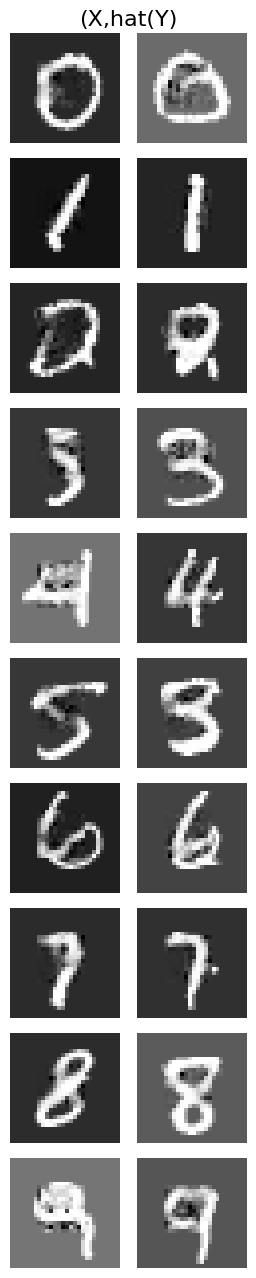

Iter: 1050, D: -0.2883, G:0.8472
Mean L1 Loss: 0.276594, Mean L2 Loss: 0.174226
Iter: 1100, D: -0.265, G:4.271
Mean L1 Loss: 0.286415, Mean L2 Loss: 0.190389
Iter: 1150, D: -0.4677, G:1.321
Mean L1 Loss: 0.257087, Mean L2 Loss: 0.160669
Iter: 1200, D: -0.6899, G:0.5626
Mean L1 Loss: 0.247607, Mean L2 Loss: 0.146275
Iter: 1250, D: -0.2704, G:1.375
Mean L1 Loss: 0.262508, Mean L2 Loss: 0.165500
Iter: 1300, D: -0.442, G:1.844
Mean L1 Loss: 0.254485, Mean L2 Loss: 0.160163
Iter: 1350, D: -0.5743, G:1.133
Mean L1 Loss: 0.243415, Mean L2 Loss: 0.149841
Iter: 1400, D: -0.447, G:2.121
Mean L1 Loss: 0.243043, Mean L2 Loss: 0.149661
Iter: 1450, D: -0.3757, G:0.9984
Mean L1 Loss: 0.237982, Mean L2 Loss: 0.147726
Iter: 1500, D: -0.3448, G:2.097
Mean L1 Loss: 0.241092, Mean L2 Loss: 0.149028
Iter: 1550, D: -0.509, G:0.8782
Mean L1 Loss: 0.237672, Mean L2 Loss: 0.145321
Iter: 1600, D: -0.4624, G:0.1036
Mean L1 Loss: 0.228112, Mean L2 Loss: 0.136846
################## save G model #################
S

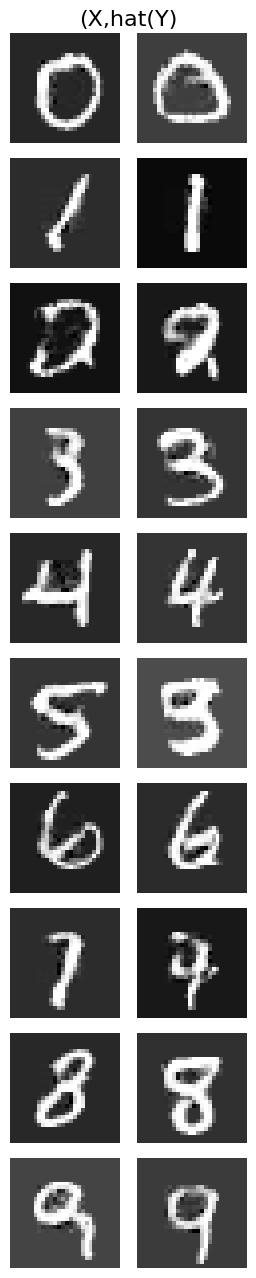

Iter: 1650, D: -0.469, G:1.414
Mean L1 Loss: 0.228682, Mean L2 Loss: 0.139776
Iter: 1700, D: -0.3969, G:1.584
Mean L1 Loss: 0.233679, Mean L2 Loss: 0.143716
Iter: 1750, D: -0.1894, G:2.456
Mean L1 Loss: 0.237435, Mean L2 Loss: 0.148580
Iter: 1800, D: -0.4121, G:2.403
Mean L1 Loss: 0.237354, Mean L2 Loss: 0.146551
Iter: 1850, D: -0.3944, G:1.224
Mean L1 Loss: 0.233360, Mean L2 Loss: 0.141686
Iter: 1900, D: -0.4098, G:2.952
Mean L1 Loss: 0.225067, Mean L2 Loss: 0.136836
################## save G model #################
Saved best model with L2: 0.1368


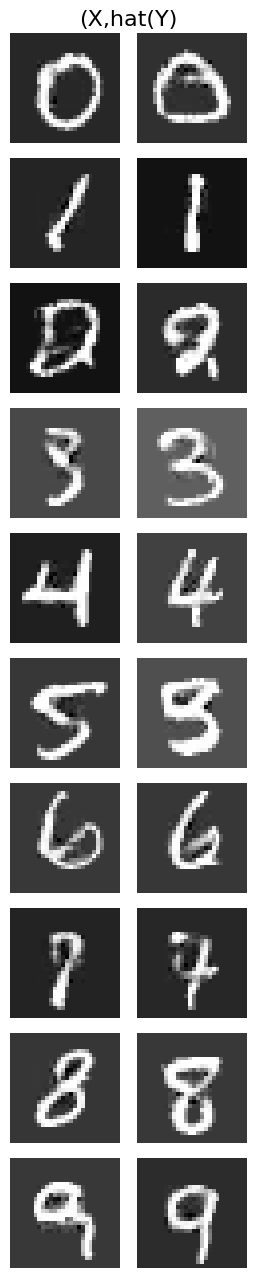

Iter: 1950, D: -0.4554, G:1.328
Mean L1 Loss: 0.218781, Mean L2 Loss: 0.132652
################## save G model #################
Saved best model with L2: 0.1327


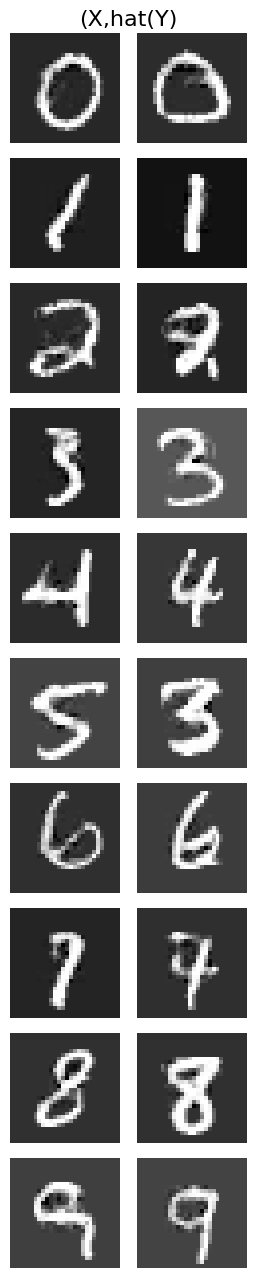

Iter: 2000, D: -0.3909, G:0.9466
Mean L1 Loss: 0.214725, Mean L2 Loss: 0.127152
################## save G model #################
Saved best model with L2: 0.1272


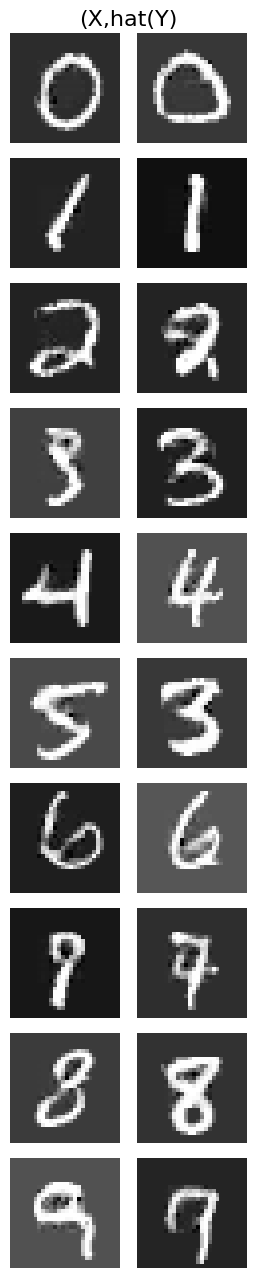

Iter: 2050, D: -0.3637, G:2.42
Mean L1 Loss: 0.228286, Mean L2 Loss: 0.140470
Iter: 2100, D: -0.3426, G:1.156
Mean L1 Loss: 0.228173, Mean L2 Loss: 0.137005
Iter: 2150, D: -0.3671, G:1.938
Mean L1 Loss: 0.223874, Mean L2 Loss: 0.137159
Iter: 2200, D: -0.3655, G:0.9346
Mean L1 Loss: 0.221921, Mean L2 Loss: 0.134727
Iter: 2250, D: -0.3572, G:0.2495
Mean L1 Loss: 0.212944, Mean L2 Loss: 0.126595
################## save G model #################
Saved best model with L2: 0.1266


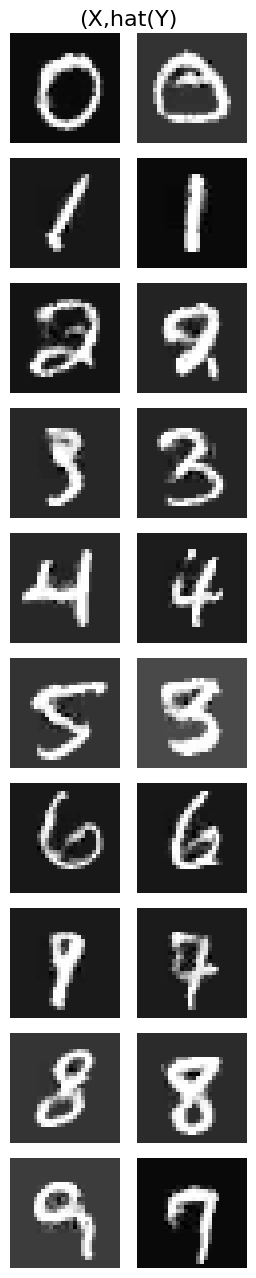

Iter: 2300, D: -0.3255, G:2.834
Mean L1 Loss: 0.226300, Mean L2 Loss: 0.138224
Iter: 2350, D: -0.4198, G:0.04046
Mean L1 Loss: 0.217781, Mean L2 Loss: 0.131128
Iter: 2400, D: -0.3392, G:2.005
Mean L1 Loss: 0.218618, Mean L2 Loss: 0.131501
Iter: 2450, D: -0.3881, G:1.384
Mean L1 Loss: 0.225169, Mean L2 Loss: 0.138249
Iter: 2500, D: -0.3906, G:0.5875
Mean L1 Loss: 0.211298, Mean L2 Loss: 0.127025
Iter: 2550, D: -0.3738, G:1.496
Mean L1 Loss: 0.210672, Mean L2 Loss: 0.125822
################## save G model #################
Saved best model with L2: 0.1258


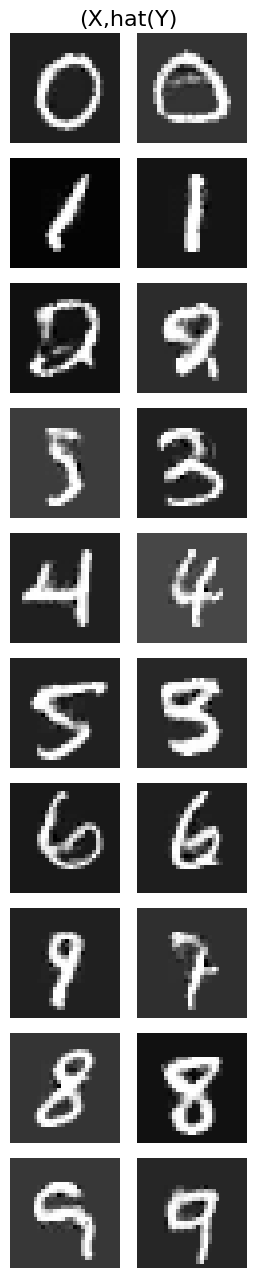

Iter: 2600, D: -0.2314, G:1.371
Mean L1 Loss: 0.223894, Mean L2 Loss: 0.139896
Iter: 2650, D: -0.248, G:1.692
Mean L1 Loss: 0.208266, Mean L2 Loss: 0.122647
################## save G model #################
Saved best model with L2: 0.1226


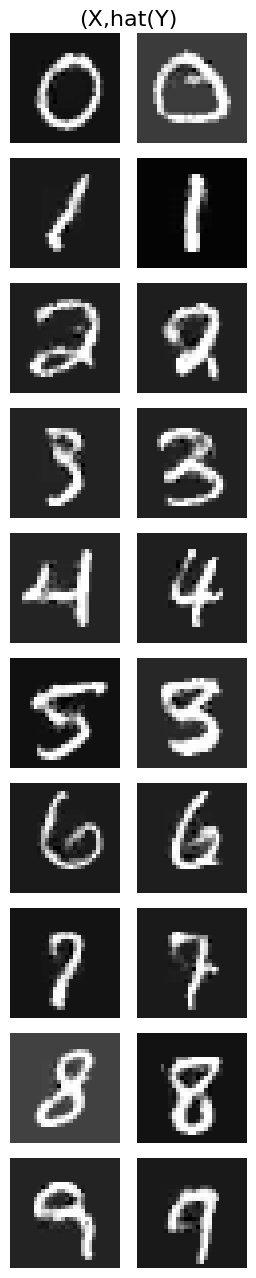

Iter: 2700, D: -0.32, G:0.08095
Mean L1 Loss: 0.215738, Mean L2 Loss: 0.132453
Iter: 2750, D: -0.2391, G:1.141
Mean L1 Loss: 0.206981, Mean L2 Loss: 0.122029
################## save G model #################
Saved best model with L2: 0.1220


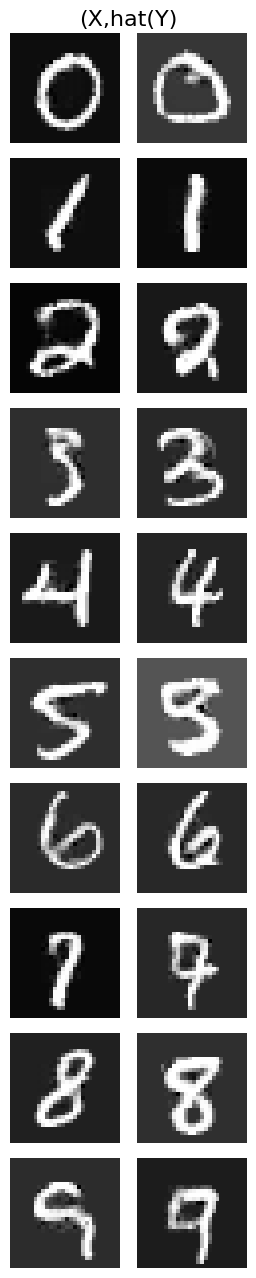

Iter: 2800, D: -0.2041, G:0.9068
Mean L1 Loss: 0.217651, Mean L2 Loss: 0.130991
Iter: 2850, D: -0.3427, G:0.2868
Mean L1 Loss: 0.217861, Mean L2 Loss: 0.134148
Iter: 2900, D: -0.1474, G:2.2
Mean L1 Loss: 0.213358, Mean L2 Loss: 0.130560
Iter: 2950, D: -0.3097, G:2.246
Mean L1 Loss: 0.211994, Mean L2 Loss: 0.129026
Iter: 3000, D: -0.09882, G:1.664
Mean L1 Loss: 0.212312, Mean L2 Loss: 0.128285
Iter: 3050, D: -0.1438, G:0.3902
Mean L1 Loss: 0.210320, Mean L2 Loss: 0.128182
Iter: 3100, D: -0.3076, G:-0.173
Mean L1 Loss: 0.215918, Mean L2 Loss: 0.131620
Iter: 3150, D: -0.2765, G:-0.4255
Mean L1 Loss: 0.207603, Mean L2 Loss: 0.125749
Iter: 3200, D: -0.3132, G:0.8424
Mean L1 Loss: 0.206120, Mean L2 Loss: 0.126271
Iter: 3250, D: -0.3329, G:1.877
Mean L1 Loss: 0.215976, Mean L2 Loss: 0.133475
Iter: 3300, D: -0.2051, G:2.068
Mean L1 Loss: 0.226525, Mean L2 Loss: 0.141845
Iter: 3350, D: -0.3113, G:0.7672
Mean L1 Loss: 0.205309, Mean L2 Loss: 0.124837
Iter: 3400, D: -0.1369, G:1.493
Mean L1 Loss:

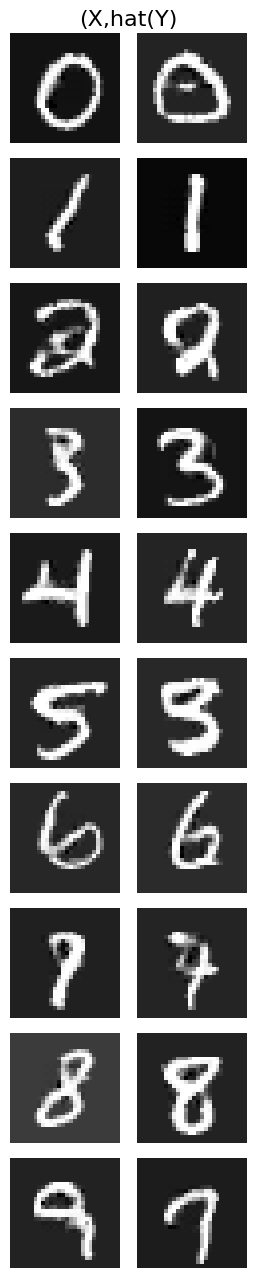

Iter: 3750, D: -0.04124, G:0.1243
Mean L1 Loss: 0.215377, Mean L2 Loss: 0.135726
Iter: 3800, D: -0.1288, G:0.9558
Mean L1 Loss: 0.215774, Mean L2 Loss: 0.135320
Iter: 3850, D: -0.1958, G:0.1251
Mean L1 Loss: 0.205912, Mean L2 Loss: 0.126327
Iter: 3900, D: -0.1828, G:1.328
Mean L1 Loss: 0.207809, Mean L2 Loss: 0.127023
Iter: 3950, D: -0.2665, G:0.08164
Mean L1 Loss: 0.197182, Mean L2 Loss: 0.119357
################## save G model #################
Saved best model with L2: 0.1194


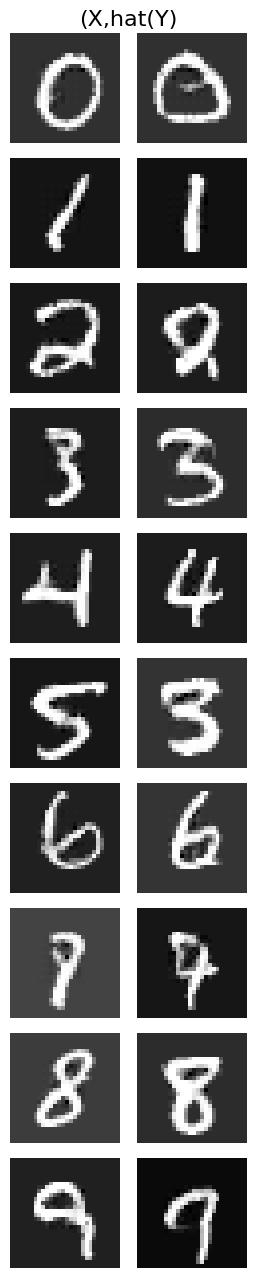

Iter: 4000, D: -0.2764, G:-0.3086
Mean L1 Loss: 0.202152, Mean L2 Loss: 0.123593
Iter: 4050, D: -0.1936, G:1.034
Mean L1 Loss: 0.197033, Mean L2 Loss: 0.119011
################## save G model #################
Saved best model with L2: 0.1190


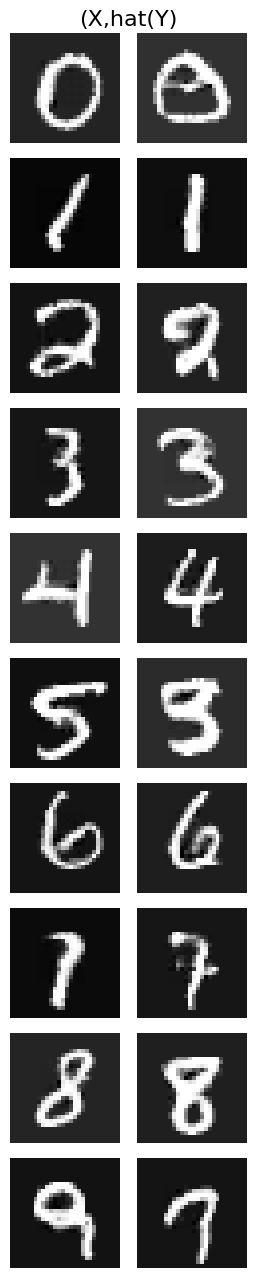

Iter: 4100, D: -0.2679, G:1.697
Mean L1 Loss: 0.203623, Mean L2 Loss: 0.124205
Iter: 4150, D: -0.1774, G:0.1353
Mean L1 Loss: 0.196830, Mean L2 Loss: 0.118474
################## save G model #################
Saved best model with L2: 0.1185


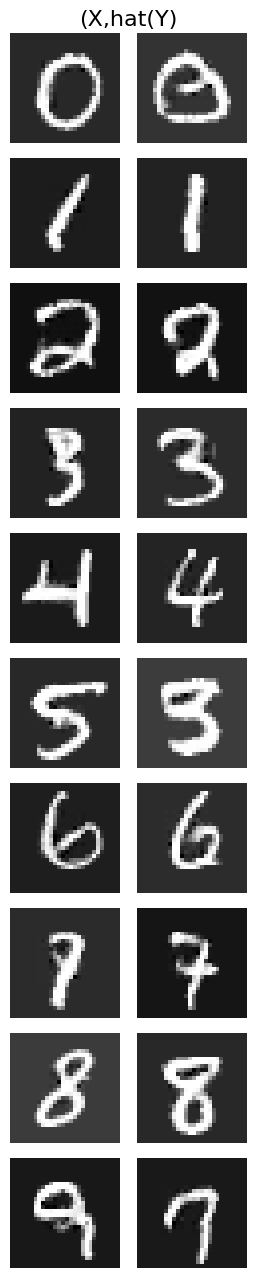

Iter: 4200, D: -0.2022, G:0.5188
Mean L1 Loss: 0.197225, Mean L2 Loss: 0.119960
Iter: 4250, D: -0.2433, G:1.327
Mean L1 Loss: 0.202850, Mean L2 Loss: 0.123172
Iter: 4300, D: -0.2099, G:0.2312
Mean L1 Loss: 0.200605, Mean L2 Loss: 0.121581
Iter: 4350, D: -0.1569, G:0.07826
Mean L1 Loss: 0.206542, Mean L2 Loss: 0.126933
Iter: 4400, D: -0.1492, G:0.4746
Mean L1 Loss: 0.196442, Mean L2 Loss: 0.119261
Iter: 4450, D: -0.1767, G:0.7251
Mean L1 Loss: 0.204366, Mean L2 Loss: 0.126712
Iter: 4500, D: -0.17, G:0.07929
Mean L1 Loss: 0.201411, Mean L2 Loss: 0.125070
Iter: 4550, D: -0.2159, G:0.09572
Mean L1 Loss: 0.207654, Mean L2 Loss: 0.129468
Iter: 4600, D: -0.2956, G:1.741
Mean L1 Loss: 0.197026, Mean L2 Loss: 0.120199
Iter: 4650, D: -0.1967, G:1.003
Mean L1 Loss: 0.199929, Mean L2 Loss: 0.121941
Iter: 4700, D: -0.2067, G:0.1481
Mean L1 Loss: 0.210507, Mean L2 Loss: 0.132791
Iter: 4750, D: -0.1682, G:0.8034
Mean L1 Loss: 0.207700, Mean L2 Loss: 0.129499
Iter: 4800, D: -0.08296, G:1.54
Mean L1 Lo

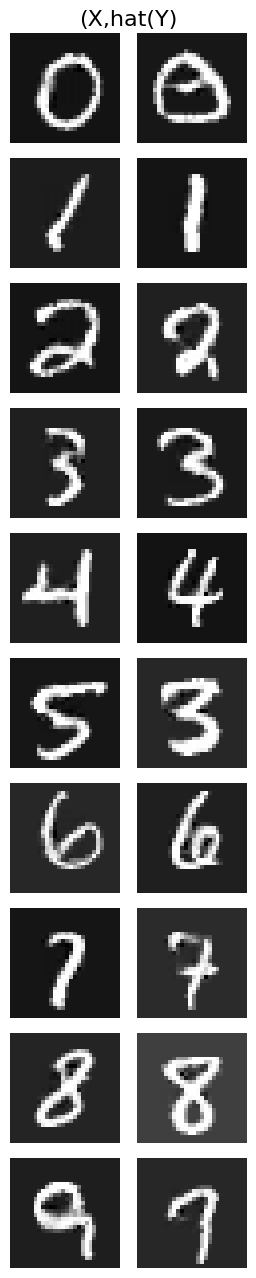

Iter: 4950, D: -0.08403, G:0.0836
Mean L1 Loss: 0.195967, Mean L2 Loss: 0.119670
Iter: 5000, D: -0.02082, G:0.4723
Mean L1 Loss: 0.207436, Mean L2 Loss: 0.130104
Iter: 5050, D: -0.1329, G:-0.1843
Mean L1 Loss: 0.200807, Mean L2 Loss: 0.123984
Iter: 5100, D: -0.2973, G:-0.4665
Mean L1 Loss: 0.198565, Mean L2 Loss: 0.121150
Iter: 5150, D: -0.07535, G:0.1427
Mean L1 Loss: 0.205005, Mean L2 Loss: 0.127106
Iter: 5200, D: -0.1392, G:1.138
Mean L1 Loss: 0.199136, Mean L2 Loss: 0.121101
Iter: 5250, D: -0.1102, G:0.3079
Mean L1 Loss: 0.196374, Mean L2 Loss: 0.119986
Iter: 5300, D: -0.1533, G:0.07248
Mean L1 Loss: 0.194976, Mean L2 Loss: 0.119356
Iter: 5350, D: -0.07056, G:-0.2681
Mean L1 Loss: 0.206835, Mean L2 Loss: 0.129542
Iter: 5400, D: -0.1537, G:1.473
Mean L1 Loss: 0.198726, Mean L2 Loss: 0.121890
Iter: 5450, D: -0.1742, G:-0.2257
Mean L1 Loss: 0.194804, Mean L2 Loss: 0.118244
Iter: 5500, D: -0.2302, G:1.439
Mean L1 Loss: 0.189855, Mean L2 Loss: 0.115129
################## save G model ##

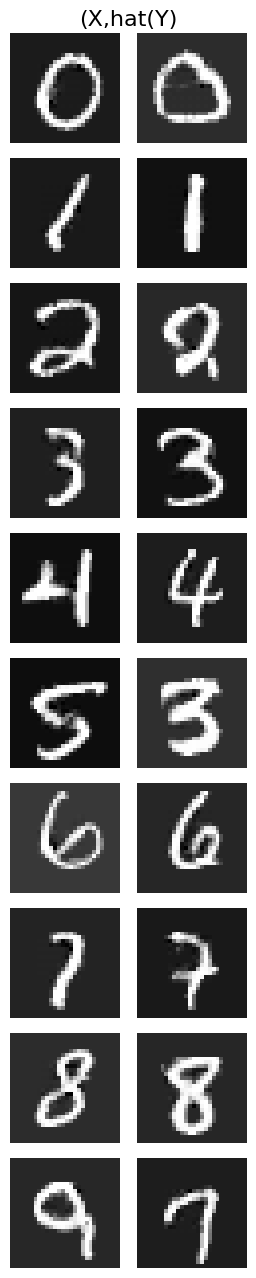

Iter: 5550, D: -0.1201, G:-0.1321
Mean L1 Loss: 0.191358, Mean L2 Loss: 0.115563
Iter: 5600, D: -0.08417, G:1.297
Mean L1 Loss: 0.197835, Mean L2 Loss: 0.121082
Iter: 5650, D: -0.1062, G:0.2679
Mean L1 Loss: 0.195745, Mean L2 Loss: 0.119996
Iter: 5700, D: -0.09504, G:0.191
Mean L1 Loss: 0.200638, Mean L2 Loss: 0.124514
Iter: 5750, D: -0.0883, G:0.1095
Mean L1 Loss: 0.193696, Mean L2 Loss: 0.119106
Iter: 5800, D: -0.1534, G:1.172
Mean L1 Loss: 0.198471, Mean L2 Loss: 0.122025
Iter: 5850, D: -0.2831, G:-0.1043
Mean L1 Loss: 0.194489, Mean L2 Loss: 0.119553
Iter: 5900, D: -0.1643, G:-0.221
Mean L1 Loss: 0.199875, Mean L2 Loss: 0.123110
Iter: 5950, D: -0.1685, G:0.4614
Mean L1 Loss: 0.189477, Mean L2 Loss: 0.114064
################## save G model #################
Saved best model with L2: 0.1141


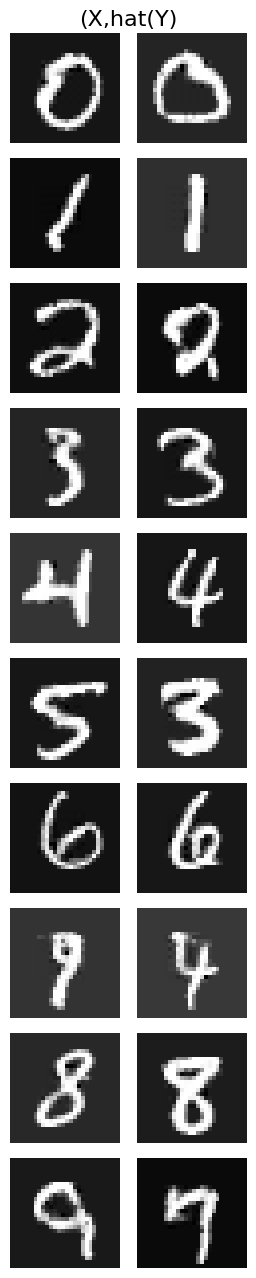

Iter: 6000, D: -0.1829, G:-0.08795
Mean L1 Loss: 0.187574, Mean L2 Loss: 0.113053
################## save G model #################
Saved best model with L2: 0.1131


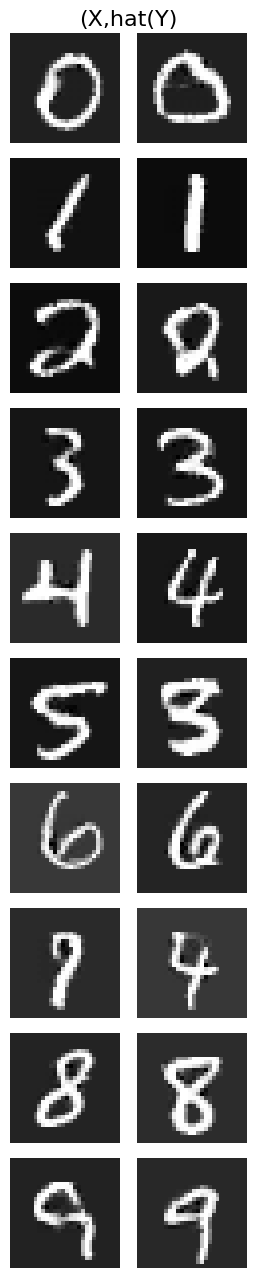

Iter: 6050, D: -0.1123, G:0.4856
Mean L1 Loss: 0.194608, Mean L2 Loss: 0.119359
Iter: 6100, D: -0.1636, G:0.9842
Mean L1 Loss: 0.191639, Mean L2 Loss: 0.115436
Iter: 6150, D: -0.152, G:0.9246
Mean L1 Loss: 0.190372, Mean L2 Loss: 0.114032
Iter: 6200, D: -0.09377, G:0.5515
Mean L1 Loss: 0.186565, Mean L2 Loss: 0.111288
################## save G model #################
Saved best model with L2: 0.1113


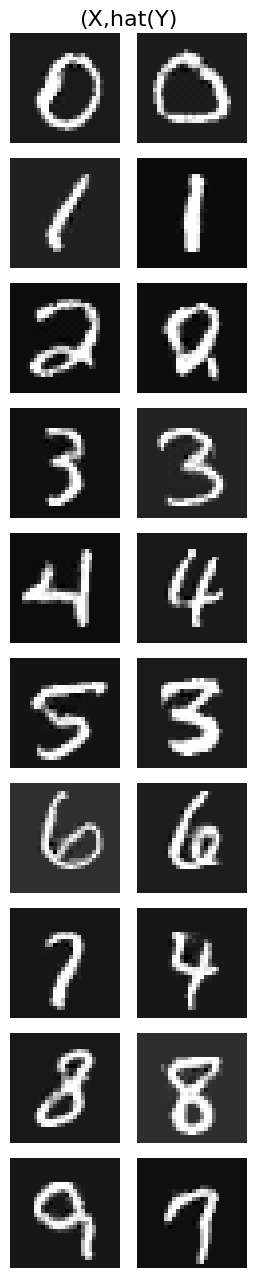

Iter: 6250, D: -0.09708, G:0.2816
Mean L1 Loss: 0.195078, Mean L2 Loss: 0.119105
Iter: 6300, D: -0.1145, G:-0.02021
Mean L1 Loss: 0.187726, Mean L2 Loss: 0.113456
Iter: 6350, D: -0.1595, G:0.7321
Mean L1 Loss: 0.193247, Mean L2 Loss: 0.117202
Iter: 6400, D: -0.1505, G:1.423
Mean L1 Loss: 0.188340, Mean L2 Loss: 0.112950
Iter: 6450, D: -0.04179, G:0.6757
Mean L1 Loss: 0.197886, Mean L2 Loss: 0.121360
Iter: 6500, D: -0.1476, G:-0.4775
Mean L1 Loss: 0.194615, Mean L2 Loss: 0.119184
Iter: 6550, D: -0.09949, G:0.5234
Mean L1 Loss: 0.191690, Mean L2 Loss: 0.115899
Iter: 6600, D: -0.2388, G:-0.905
Mean L1 Loss: 0.190233, Mean L2 Loss: 0.115838
Iter: 6650, D: -0.1682, G:0.885
Mean L1 Loss: 0.191048, Mean L2 Loss: 0.115928
Iter: 6700, D: -0.1758, G:-0.5767
Mean L1 Loss: 0.196963, Mean L2 Loss: 0.120936
Iter: 6750, D: -0.1456, G:0.3268
Mean L1 Loss: 0.189123, Mean L2 Loss: 0.114497
Iter: 6800, D: -0.0469, G:0.7301
Mean L1 Loss: 0.194270, Mean L2 Loss: 0.118916
Iter: 6850, D: -0.0746, G:1.042
Mea

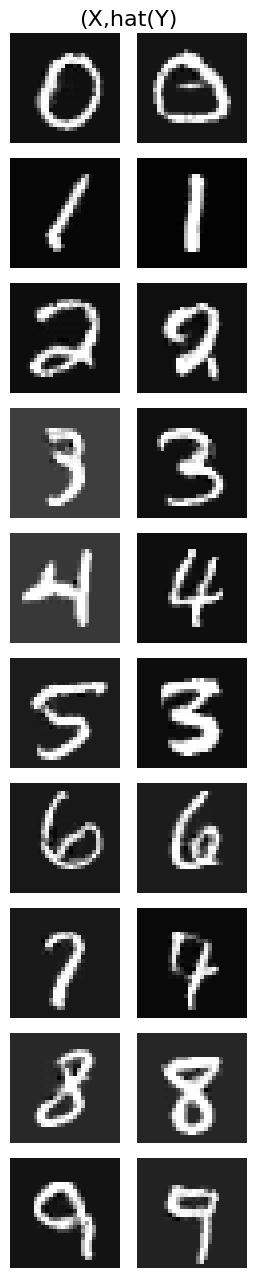

Iter: 7800, D: -0.05764, G:0.6836
Mean L1 Loss: 0.188239, Mean L2 Loss: 0.112939
Iter: 7850, D: -0.04251, G:0.4325
Mean L1 Loss: 0.193011, Mean L2 Loss: 0.116707
Iter: 7900, D: -0.1424, G:-0.1728
Mean L1 Loss: 0.183266, Mean L2 Loss: 0.109106
################## save G model #################
Saved best model with L2: 0.1091


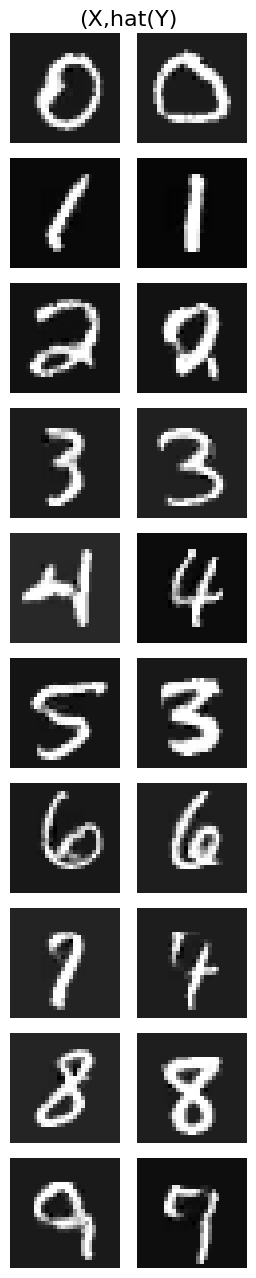

Iter: 7950, D: 0.007751, G:-0.1147
Mean L1 Loss: 0.183552, Mean L2 Loss: 0.110568
Iter: 8000, D: -0.1466, G:0.6696
Mean L1 Loss: 0.187644, Mean L2 Loss: 0.112811
Iter: 8050, D: -0.1398, G:0.4982
Mean L1 Loss: 0.186416, Mean L2 Loss: 0.111983
Iter: 8100, D: -0.1492, G:0.6721
Mean L1 Loss: 0.191988, Mean L2 Loss: 0.116993
Iter: 8150, D: -0.09925, G:0.622
Mean L1 Loss: 0.189658, Mean L2 Loss: 0.113734
Iter: 8200, D: -0.149, G:0.1492
Mean L1 Loss: 0.185938, Mean L2 Loss: 0.111725
Iter: 8250, D: -0.07439, G:0.07987
Mean L1 Loss: 0.186202, Mean L2 Loss: 0.112486
Iter: 8300, D: -0.08038, G:0.8349
Mean L1 Loss: 0.191241, Mean L2 Loss: 0.115779
Iter: 8350, D: -0.1086, G:-0.1664
Mean L1 Loss: 0.180809, Mean L2 Loss: 0.108009
################## save G model #################
Saved best model with L2: 0.1080


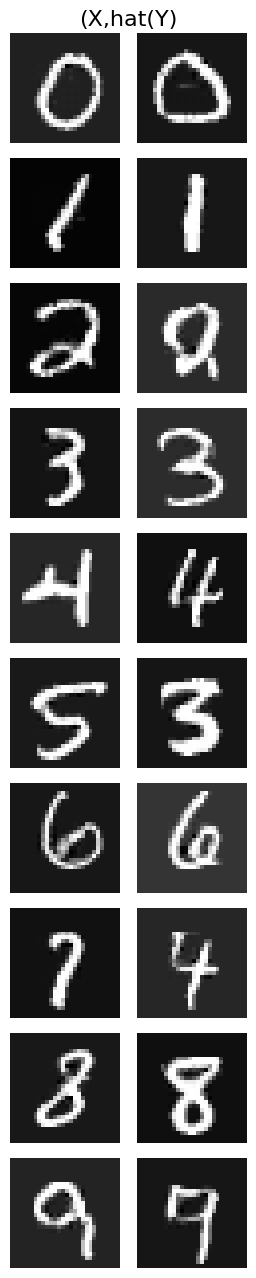

Iter: 8400, D: -0.117, G:0.3814
Mean L1 Loss: 0.182498, Mean L2 Loss: 0.109012
Iter: 8450, D: -0.08699, G:0.5148
Mean L1 Loss: 0.186245, Mean L2 Loss: 0.112071
Iter: 8500, D: -0.1718, G:1.082
Mean L1 Loss: 0.191695, Mean L2 Loss: 0.116153
Iter: 8550, D: -0.09047, G:0.3905
Mean L1 Loss: 0.185095, Mean L2 Loss: 0.110860
Iter: 8600, D: -0.1128, G:0.1205
Mean L1 Loss: 0.186349, Mean L2 Loss: 0.112237
Iter: 8650, D: -0.08391, G:0.2225
Mean L1 Loss: 0.182877, Mean L2 Loss: 0.109290
Iter: 8700, D: -0.1235, G:0.5334
Mean L1 Loss: 0.181686, Mean L2 Loss: 0.107476
################## save G model #################
Saved best model with L2: 0.1075


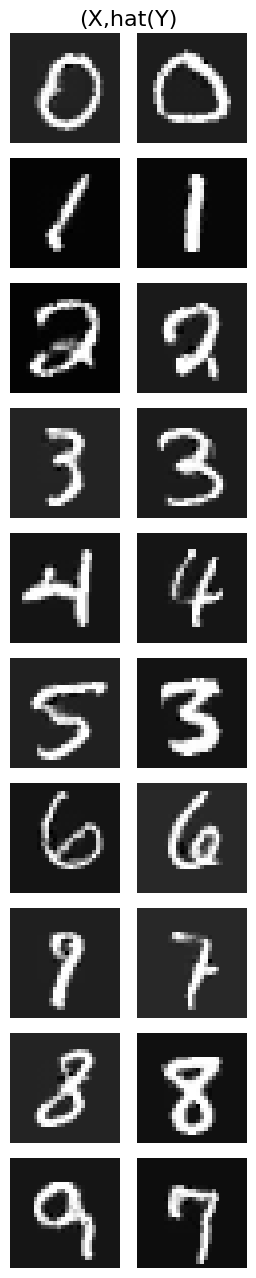

Iter: 8750, D: -0.1228, G:0.3099
Mean L1 Loss: 0.184123, Mean L2 Loss: 0.109942
Iter: 8800, D: -0.03864, G:-0.04198
Mean L1 Loss: 0.191862, Mean L2 Loss: 0.117909
Iter: 8850, D: -0.1759, G:-0.2275
Mean L1 Loss: 0.189039, Mean L2 Loss: 0.115006
Iter: 8900, D: -0.1564, G:0.8266
Mean L1 Loss: 0.181751, Mean L2 Loss: 0.108112
Iter: 8950, D: -0.1384, G:-0.01075
Mean L1 Loss: 0.183105, Mean L2 Loss: 0.109249
Iter: 9000, D: -0.09756, G:0.1042
Mean L1 Loss: 0.183871, Mean L2 Loss: 0.109947
Iter: 9050, D: -0.131, G:0.00496
Mean L1 Loss: 0.186080, Mean L2 Loss: 0.112755
Iter: 9100, D: -0.1209, G:0.1306
Mean L1 Loss: 0.183547, Mean L2 Loss: 0.109813
Iter: 9150, D: -0.2226, G:-0.4488
Mean L1 Loss: 0.188168, Mean L2 Loss: 0.114009
Iter: 9200, D: -0.1148, G:0.6871
Mean L1 Loss: 0.180286, Mean L2 Loss: 0.106484
################## save G model #################
Saved best model with L2: 0.1065


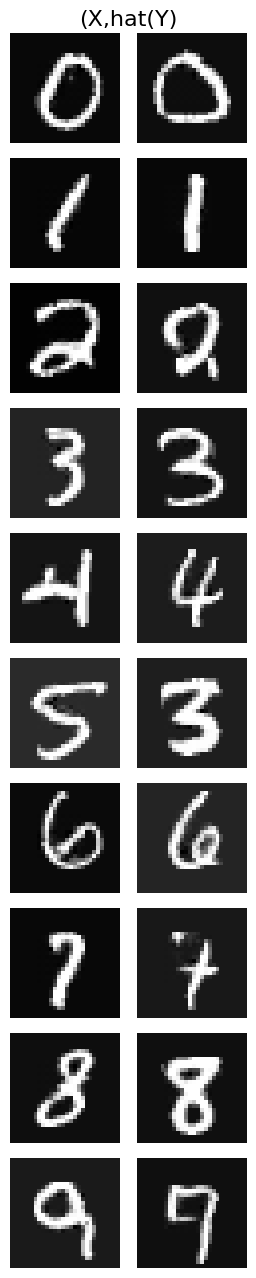

Iter: 9250, D: -0.111, G:0.5081
Mean L1 Loss: 0.181474, Mean L2 Loss: 0.107114
Iter: 9300, D: -0.07694, G:0.1333
Mean L1 Loss: 0.184192, Mean L2 Loss: 0.110212
Iter: 9350, D: -0.06471, G:-0.1795
Mean L1 Loss: 0.192414, Mean L2 Loss: 0.118139
Iter: 9400, D: -0.0939, G:0.08212
Mean L1 Loss: 0.184859, Mean L2 Loss: 0.110933
Iter: 9450, D: -0.05448, G:0.01369
Mean L1 Loss: 0.190140, Mean L2 Loss: 0.116343
Iter: 9500, D: -0.1345, G:0.34
Mean L1 Loss: 0.188387, Mean L2 Loss: 0.114499
Iter: 9550, D: -0.07505, G:-0.2551
Mean L1 Loss: 0.190950, Mean L2 Loss: 0.116881
Iter: 9600, D: -0.08488, G:0.6132
Mean L1 Loss: 0.188245, Mean L2 Loss: 0.112909
Iter: 9650, D: -0.09086, G:0.1226
Mean L1 Loss: 0.180072, Mean L2 Loss: 0.106584
Iter: 9700, D: -0.03874, G:0.1062
Mean L1 Loss: 0.180174, Mean L2 Loss: 0.107402
Iter: 9750, D: -0.1446, G:0.6906
Mean L1 Loss: 0.182455, Mean L2 Loss: 0.108475
Iter: 9800, D: -0.1583, G:0.2603
Mean L1 Loss: 0.182610, Mean L2 Loss: 0.108888
Iter: 9850, D: -0.1157, G:0.0634

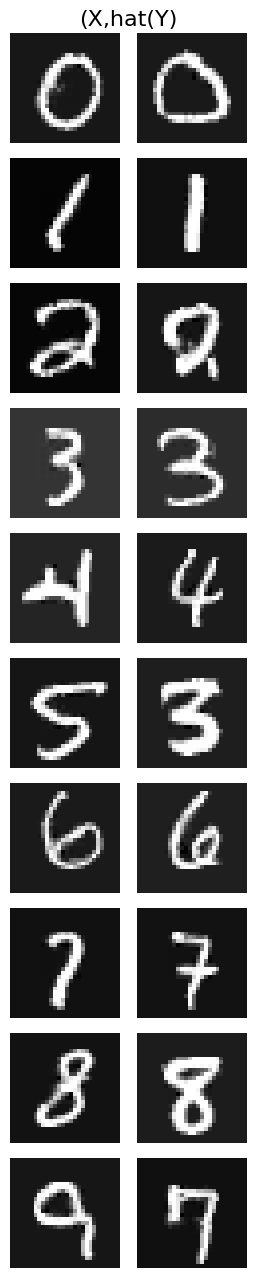

Iter: 10000, D: -0.08236, G:0.0386
Mean L1 Loss: 0.180976, Mean L2 Loss: 0.108142
Iter: 10050, D: -0.0688, G:-0.02312
Mean L1 Loss: 0.184715, Mean L2 Loss: 0.111006
Iter: 10100, D: -0.06961, G:-0.139
Mean L1 Loss: 0.189679, Mean L2 Loss: 0.114975
Iter: 10150, D: -0.1607, G:0.7054
Mean L1 Loss: 0.178201, Mean L2 Loss: 0.105119
################## save G model #################
Saved best model with L2: 0.1051


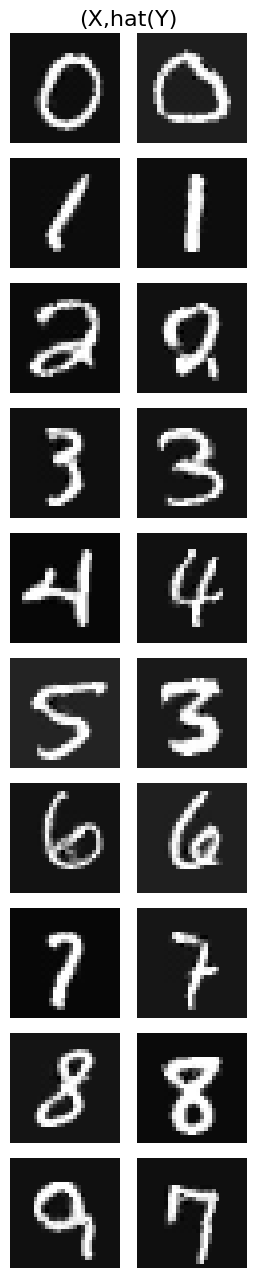

Iter: 10200, D: -0.02613, G:-0.1308
Mean L1 Loss: 0.184663, Mean L2 Loss: 0.110883
Iter: 10250, D: -0.1069, G:-0.3507
Mean L1 Loss: 0.184865, Mean L2 Loss: 0.111401
Iter: 10300, D: -0.1348, G:0.583
Mean L1 Loss: 0.181432, Mean L2 Loss: 0.108147
Iter: 10350, D: -0.1263, G:-0.4549
Mean L1 Loss: 0.183186, Mean L2 Loss: 0.110214
Iter: 10400, D: -0.08709, G:0.1586
Mean L1 Loss: 0.182919, Mean L2 Loss: 0.109591
Iter: 10450, D: -0.1306, G:0.3137
Mean L1 Loss: 0.179862, Mean L2 Loss: 0.106498
Iter: 10500, D: -0.06486, G:-0.3924
Mean L1 Loss: 0.182395, Mean L2 Loss: 0.108744
Iter: 10550, D: -0.08607, G:-0.5498
Mean L1 Loss: 0.183406, Mean L2 Loss: 0.110570
Iter: 10600, D: -0.09802, G:0.4235
Mean L1 Loss: 0.185574, Mean L2 Loss: 0.112118
Iter: 10650, D: -0.1008, G:-0.1761
Mean L1 Loss: 0.181917, Mean L2 Loss: 0.108641
Iter: 10700, D: -0.1006, G:0.09116
Mean L1 Loss: 0.179405, Mean L2 Loss: 0.106919
Iter: 10750, D: -0.05165, G:0.1708
Mean L1 Loss: 0.180472, Mean L2 Loss: 0.107298
Iter: 10800, D: 

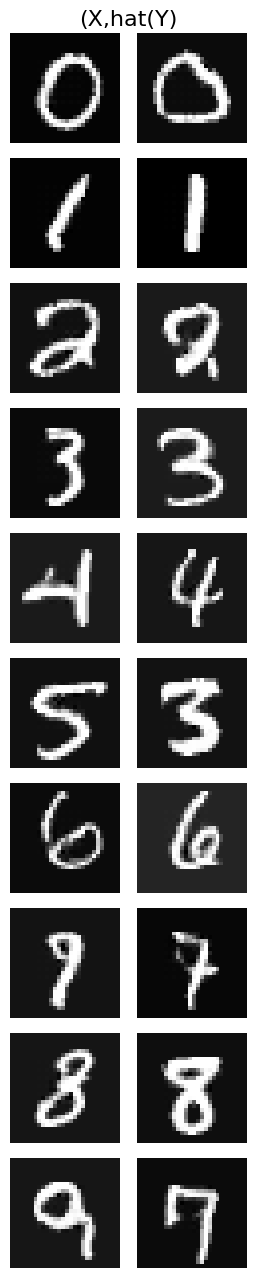

Iter: 11200, D: -0.06157, G:0.6149
Mean L1 Loss: 0.186280, Mean L2 Loss: 0.112085
Iter: 11250, D: -0.04765, G:-0.2411
Mean L1 Loss: 0.180438, Mean L2 Loss: 0.107520
Iter: 11300, D: -0.06326, G:-0.2085
Mean L1 Loss: 0.182093, Mean L2 Loss: 0.108654
Iter: 11350, D: -0.0613, G:0.6642
Mean L1 Loss: 0.183657, Mean L2 Loss: 0.109733
Iter: 11400, D: -0.08923, G:0.2824
Mean L1 Loss: 0.184173, Mean L2 Loss: 0.110389
Iter: 11450, D: -0.03967, G:-0.04783
Mean L1 Loss: 0.181307, Mean L2 Loss: 0.108630
Iter: 11500, D: -0.07362, G:0.07507
Mean L1 Loss: 0.176900, Mean L2 Loss: 0.104557
################## save G model #################
Saved best model with L2: 0.1046


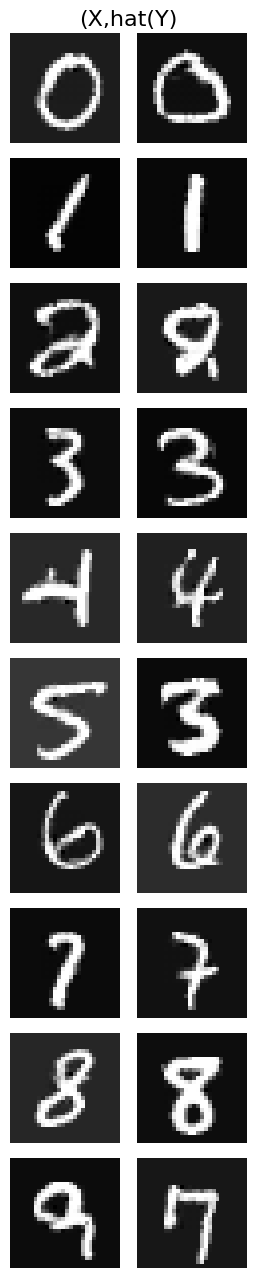

Iter: 11550, D: -0.0002725, G:-0.5312
Mean L1 Loss: 0.185453, Mean L2 Loss: 0.112361
Iter: 11600, D: -0.1288, G:-0.1416
Mean L1 Loss: 0.183336, Mean L2 Loss: 0.110128
Iter: 11650, D: -0.1111, G:-0.287
Mean L1 Loss: 0.184220, Mean L2 Loss: 0.110584
Iter: 11700, D: -0.08263, G:-0.6696
Mean L1 Loss: 0.178398, Mean L2 Loss: 0.106410
Iter: 11750, D: -0.07068, G:-0.2221
Mean L1 Loss: 0.190727, Mean L2 Loss: 0.116368
Iter: 11800, D: -0.1297, G:0.3787
Mean L1 Loss: 0.180313, Mean L2 Loss: 0.107026
Iter: 11850, D: -0.06632, G:-0.4255
Mean L1 Loss: 0.178922, Mean L2 Loss: 0.106389
Iter: 11900, D: -0.08417, G:-0.3283
Mean L1 Loss: 0.181583, Mean L2 Loss: 0.108412
Iter: 11950, D: -0.1052, G:0.3972
Mean L1 Loss: 0.178156, Mean L2 Loss: 0.105635
Iter: 12000, D: -0.07071, G:-0.3905
Mean L1 Loss: 0.177242, Mean L2 Loss: 0.105242
Iter: 12050, D: -0.07031, G:-0.5618
Mean L1 Loss: 0.180439, Mean L2 Loss: 0.107671
Iter: 12100, D: -0.08199, G:0.2262
Mean L1 Loss: 0.176958, Mean L2 Loss: 0.104334
##########

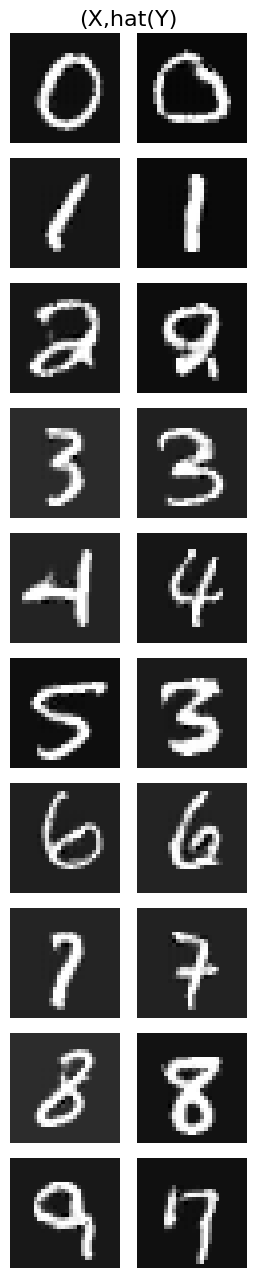

Iter: 12150, D: -0.05641, G:0.09577
Mean L1 Loss: 0.180580, Mean L2 Loss: 0.107520
Iter: 12200, D: -0.109, G:-0.1553
Mean L1 Loss: 0.181556, Mean L2 Loss: 0.108959
Iter: 12250, D: -0.1431, G:-0.2239
Mean L1 Loss: 0.185744, Mean L2 Loss: 0.110956
Iter: 12300, D: -0.1305, G:0.6025
Mean L1 Loss: 0.185859, Mean L2 Loss: 0.111372
Iter: 12350, D: -0.07768, G:-0.655
Mean L1 Loss: 0.177354, Mean L2 Loss: 0.105658
Iter: 12400, D: -0.09055, G:0.3249
Mean L1 Loss: 0.179697, Mean L2 Loss: 0.106632
Iter: 12450, D: -0.06642, G:0.1346
Mean L1 Loss: 0.178518, Mean L2 Loss: 0.105934
Iter: 12500, D: -0.05291, G:-0.2919
Mean L1 Loss: 0.184176, Mean L2 Loss: 0.110760
Iter: 12550, D: -0.1105, G:0.05175
Mean L1 Loss: 0.176475, Mean L2 Loss: 0.103903
################## save G model #################
Saved best model with L2: 0.1039


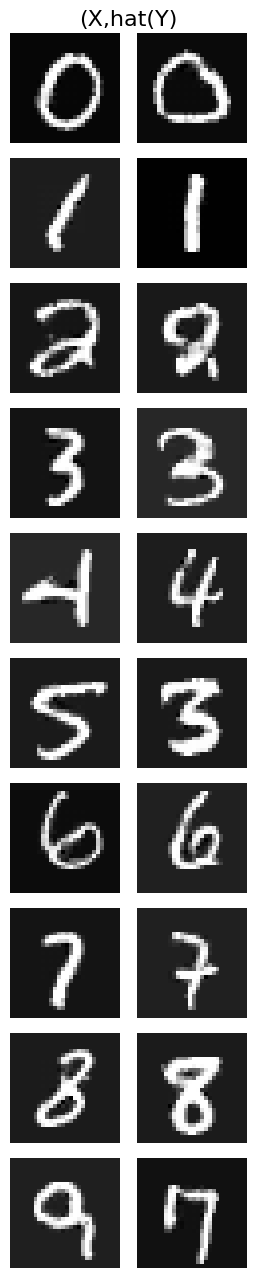

Iter: 12600, D: -0.1006, G:0.009909
Mean L1 Loss: 0.180706, Mean L2 Loss: 0.107659
Iter: 12650, D: -0.1105, G:-0.8636
Mean L1 Loss: 0.180968, Mean L2 Loss: 0.108244
Iter: 12700, D: -0.09336, G:-0.3896
Mean L1 Loss: 0.182650, Mean L2 Loss: 0.108929
Iter: 12750, D: -0.09174, G:-0.1263
Mean L1 Loss: 0.174540, Mean L2 Loss: 0.102301
################## save G model #################
Saved best model with L2: 0.1023


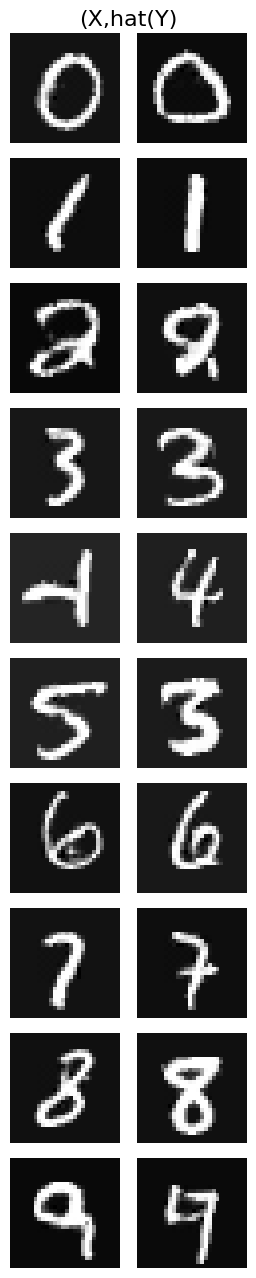

Iter: 12800, D: -0.1068, G:0.1643
Mean L1 Loss: 0.176083, Mean L2 Loss: 0.103864
Iter: 12850, D: -0.04239, G:0.03912
Mean L1 Loss: 0.179231, Mean L2 Loss: 0.107068
Iter: 12900, D: -0.09259, G:0.03192
Mean L1 Loss: 0.178638, Mean L2 Loss: 0.105621
Iter: 12950, D: -0.09125, G:-0.01765
Mean L1 Loss: 0.179520, Mean L2 Loss: 0.106662
Iter: 13000, D: -0.05416, G:-0.2226
Mean L1 Loss: 0.177627, Mean L2 Loss: 0.105494
Iter: 13050, D: -0.1042, G:0.1623
Mean L1 Loss: 0.186564, Mean L2 Loss: 0.113110
Iter: 13100, D: -0.04734, G:-0.4138
Mean L1 Loss: 0.178302, Mean L2 Loss: 0.105590
Iter: 13150, D: -0.1233, G:0.2779
Mean L1 Loss: 0.176107, Mean L2 Loss: 0.104011
Iter: 13200, D: -0.07981, G:0.3559
Mean L1 Loss: 0.174611, Mean L2 Loss: 0.102158
################## save G model #################
Saved best model with L2: 0.1022


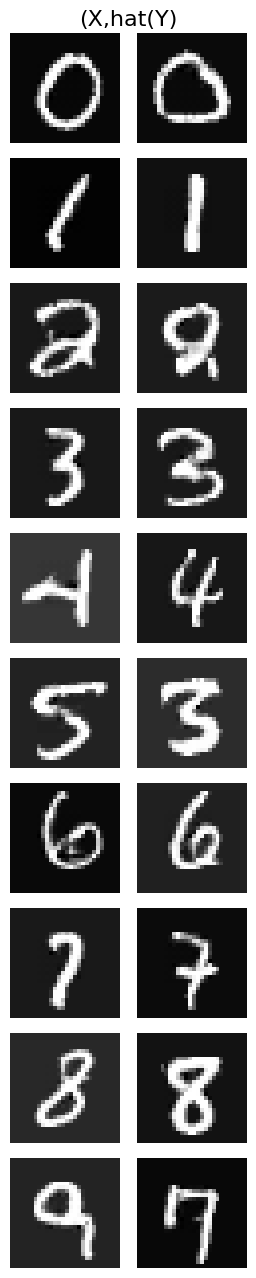

Iter: 13250, D: -0.04538, G:-0.5606
Mean L1 Loss: 0.176856, Mean L2 Loss: 0.104430
Iter: 13300, D: -0.1257, G:-0.7043
Mean L1 Loss: 0.175395, Mean L2 Loss: 0.103708
Iter: 13350, D: -0.09824, G:-0.247
Mean L1 Loss: 0.178072, Mean L2 Loss: 0.105393
Iter: 13400, D: -0.1087, G:-0.3261
Mean L1 Loss: 0.174994, Mean L2 Loss: 0.103243
Iter: 13450, D: -0.08139, G:0.2426
Mean L1 Loss: 0.181153, Mean L2 Loss: 0.108004
Iter: 13500, D: -0.08648, G:0.1739
Mean L1 Loss: 0.178986, Mean L2 Loss: 0.105811
Iter: 13550, D: -0.09118, G:-0.1425
Mean L1 Loss: 0.184364, Mean L2 Loss: 0.111422
Iter: 13600, D: -0.06645, G:-0.3546
Mean L1 Loss: 0.174933, Mean L2 Loss: 0.103032
Iter: 13650, D: -0.09718, G:0.1259
Mean L1 Loss: 0.173561, Mean L2 Loss: 0.101321
################## save G model #################
Saved best model with L2: 0.1013


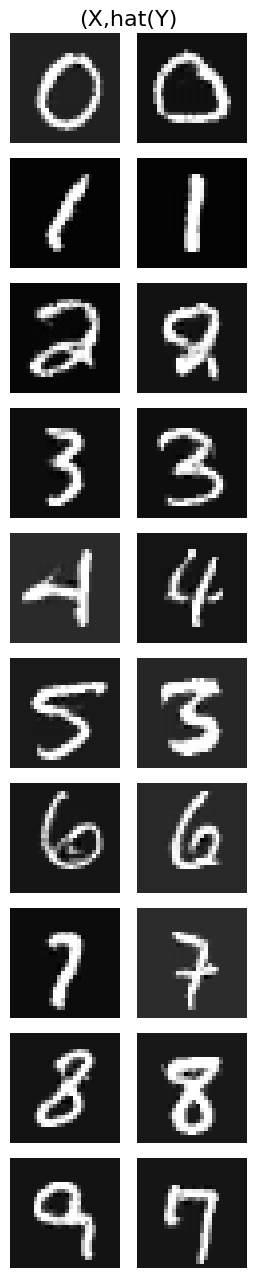

Iter: 13700, D: -0.07192, G:-0.5367
Mean L1 Loss: 0.175995, Mean L2 Loss: 0.104270
Iter: 13750, D: -0.1279, G:0.09456
Mean L1 Loss: 0.175221, Mean L2 Loss: 0.102968
Iter: 13800, D: -0.09979, G:-0.3898
Mean L1 Loss: 0.176384, Mean L2 Loss: 0.104137
Iter: 13850, D: -0.08136, G:-0.5953
Mean L1 Loss: 0.181055, Mean L2 Loss: 0.108262
Iter: 13900, D: -0.068, G:-0.2361
Mean L1 Loss: 0.174956, Mean L2 Loss: 0.102601
Iter: 13950, D: -0.08059, G:0.07524
Mean L1 Loss: 0.179593, Mean L2 Loss: 0.106486
Iter: 14000, D: -0.08308, G:-0.09632
Mean L1 Loss: 0.174239, Mean L2 Loss: 0.102225
Iter: 14050, D: -0.08659, G:-0.2791
Mean L1 Loss: 0.181033, Mean L2 Loss: 0.108288
Iter: 14100, D: -0.05711, G:-0.6954
Mean L1 Loss: 0.177650, Mean L2 Loss: 0.105654
Iter: 14150, D: -0.07608, G:-0.342
Mean L1 Loss: 0.181569, Mean L2 Loss: 0.108313
Iter: 14200, D: -0.1323, G:-0.01375
Mean L1 Loss: 0.176214, Mean L2 Loss: 0.103511
Iter: 14250, D: -0.1181, G:-0.4969
Mean L1 Loss: 0.173148, Mean L2 Loss: 0.100962
########

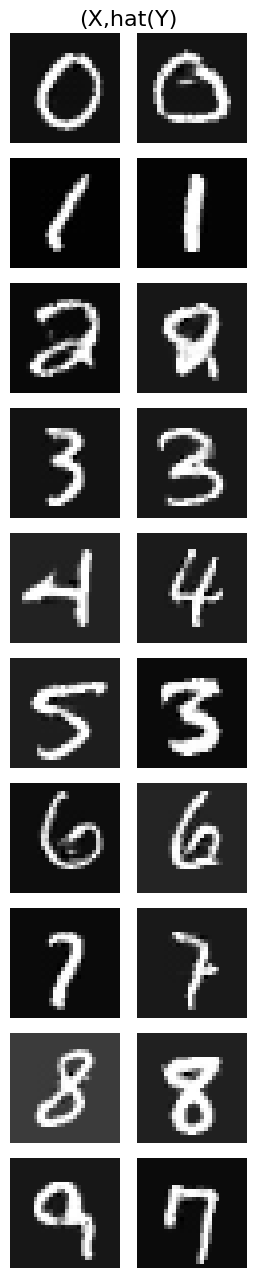

Iter: 14300, D: -0.07837, G:-0.2266
Mean L1 Loss: 0.175672, Mean L2 Loss: 0.103562
Iter: 14350, D: -0.05739, G:-0.4008
Mean L1 Loss: 0.181579, Mean L2 Loss: 0.108416
Iter: 14400, D: -0.1235, G:-0.5811
Mean L1 Loss: 0.175033, Mean L2 Loss: 0.102811
Iter: 14450, D: -0.04132, G:-0.009469
Mean L1 Loss: 0.178301, Mean L2 Loss: 0.104993
Iter: 14500, D: -0.1099, G:-0.01538
Mean L1 Loss: 0.179059, Mean L2 Loss: 0.106498
Iter: 14550, D: -0.06963, G:-0.316
Mean L1 Loss: 0.175536, Mean L2 Loss: 0.103440
Iter: 14600, D: -0.06934, G:-0.2654
Mean L1 Loss: 0.179091, Mean L2 Loss: 0.106735
Iter: 14650, D: -0.0451, G:-0.2457
Mean L1 Loss: 0.183760, Mean L2 Loss: 0.110401
Iter: 14700, D: -0.07723, G:-0.1971
Mean L1 Loss: 0.176448, Mean L2 Loss: 0.104279
Iter: 14750, D: -0.1343, G:-0.3607
Mean L1 Loss: 0.173468, Mean L2 Loss: 0.101270
Iter: 14800, D: -0.06421, G:-0.3459
Mean L1 Loss: 0.175952, Mean L2 Loss: 0.103581
Iter: 14850, D: -0.109, G:-0.1497
Mean L1 Loss: 0.176529, Mean L2 Loss: 0.104337
Iter: 14

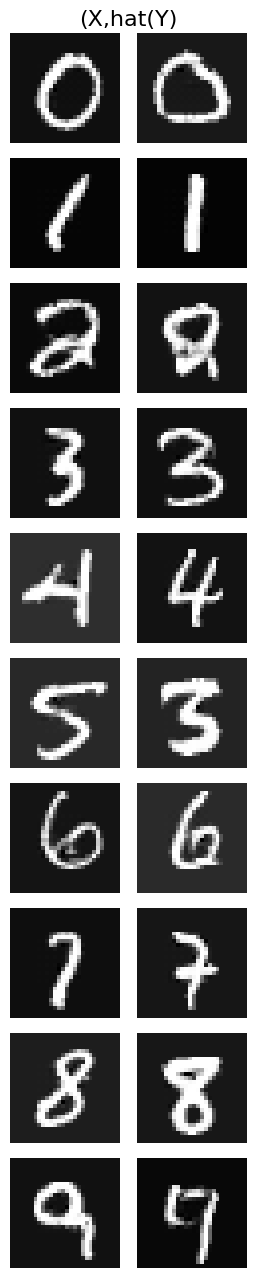

Iter: 14950, D: -0.07167, G:0.06081
Mean L1 Loss: 0.173900, Mean L2 Loss: 0.101142
Iter: 15000, D: -0.08345, G:-0.1677
Mean L1 Loss: 0.176736, Mean L2 Loss: 0.104342
Iter: 15050, D: -0.05738, G:-0.5176
Mean L1 Loss: 0.175197, Mean L2 Loss: 0.103007
Iter: 15100, D: -0.07603, G:-0.213
Mean L1 Loss: 0.176390, Mean L2 Loss: 0.103605
Iter: 15150, D: -0.05011, G:0.2451
Mean L1 Loss: 0.178544, Mean L2 Loss: 0.105445
Iter: 15200, D: -0.07081, G:-0.2082
Mean L1 Loss: 0.177623, Mean L2 Loss: 0.105170
Iter: 15250, D: -0.08197, G:-0.3883
Mean L1 Loss: 0.174446, Mean L2 Loss: 0.101922
Iter: 15300, D: -0.1058, G:0.03124
Mean L1 Loss: 0.180045, Mean L2 Loss: 0.106436
Iter: 15350, D: -0.06864, G:-0.5214
Mean L1 Loss: 0.180798, Mean L2 Loss: 0.107754
Iter: 15400, D: -0.09088, G:-0.2134
Mean L1 Loss: 0.175695, Mean L2 Loss: 0.103670
Iter: 15450, D: -0.1212, G:0.04842
Mean L1 Loss: 0.173422, Mean L2 Loss: 0.101180
Iter: 15500, D: -0.07128, G:-0.4109
Mean L1 Loss: 0.174336, Mean L2 Loss: 0.101848
Iter: 15

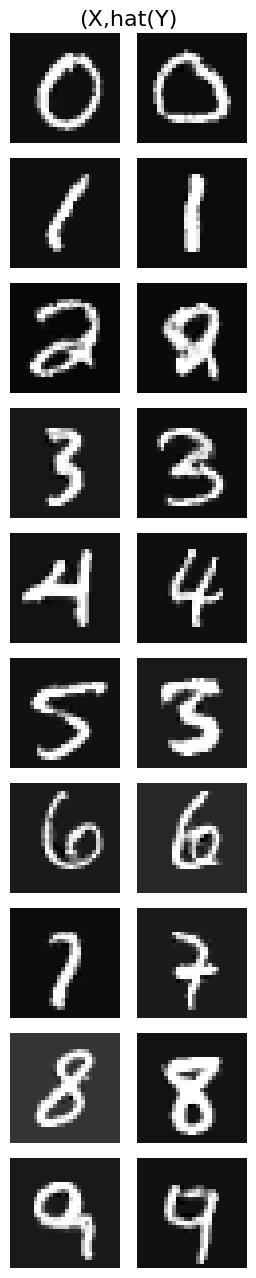

Iter: 15600, D: -0.1029, G:-0.079
Mean L1 Loss: 0.172386, Mean L2 Loss: 0.100255
Iter: 15650, D: -0.08685, G:0.1134
Mean L1 Loss: 0.173011, Mean L2 Loss: 0.100671
Iter: 15700, D: -0.09729, G:-0.006919
Mean L1 Loss: 0.175429, Mean L2 Loss: 0.103116
Iter: 15750, D: -0.06921, G:0.01517
Mean L1 Loss: 0.174155, Mean L2 Loss: 0.102257
Iter: 15800, D: -0.1165, G:-0.2123
Mean L1 Loss: 0.176707, Mean L2 Loss: 0.104331
Iter: 15850, D: -0.04272, G:-0.3308
Mean L1 Loss: 0.174988, Mean L2 Loss: 0.102652
Iter: 15900, D: -0.09777, G:-0.3472
Mean L1 Loss: 0.176794, Mean L2 Loss: 0.104060
Iter: 15950, D: -0.08183, G:-0.5816
Mean L1 Loss: 0.177626, Mean L2 Loss: 0.105296
Iter: 16000, D: -0.02875, G:-0.5398
Mean L1 Loss: 0.173317, Mean L2 Loss: 0.100784
Iter: 16050, D: -0.1096, G:-0.5689
Mean L1 Loss: 0.172155, Mean L2 Loss: 0.100501
Iter: 16100, D: -0.05138, G:-0.4188
Mean L1 Loss: 0.174119, Mean L2 Loss: 0.101988
Iter: 16150, D: -0.07162, G:-0.05491
Mean L1 Loss: 0.173738, Mean L2 Loss: 0.101574
Iter: 

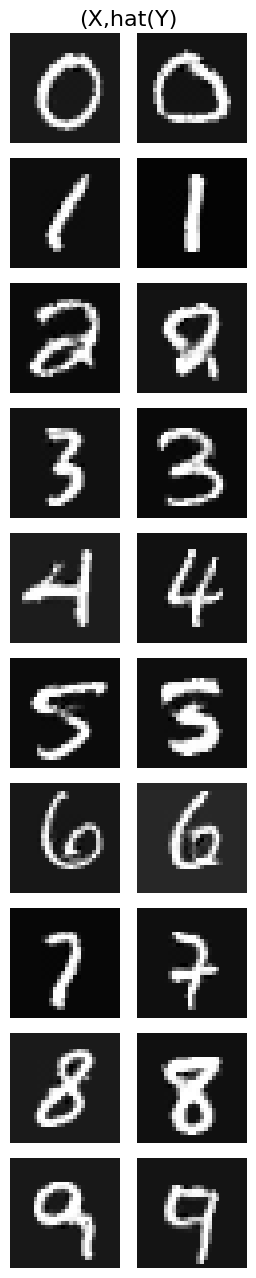

Iter: 17550, D: -0.04092, G:-0.1894
Mean L1 Loss: 0.172883, Mean L2 Loss: 0.101104
Iter: 17600, D: -0.07614, G:-0.425
Mean L1 Loss: 0.173505, Mean L2 Loss: 0.101277
Iter: 17650, D: -0.01323, G:-0.5929
Mean L1 Loss: 0.172166, Mean L2 Loss: 0.099891
Iter: 17700, D: -0.04727, G:-0.6567
Mean L1 Loss: 0.172607, Mean L2 Loss: 0.100497
Iter: 17750, D: -0.06396, G:-0.5228
Mean L1 Loss: 0.172061, Mean L2 Loss: 0.099781
Iter: 17800, D: -0.06092, G:-0.2715
Mean L1 Loss: 0.174190, Mean L2 Loss: 0.102178
Iter: 17850, D: -0.03578, G:-0.6523
Mean L1 Loss: 0.172651, Mean L2 Loss: 0.100132
Iter: 17900, D: -0.07083, G:-0.4836
Mean L1 Loss: 0.172447, Mean L2 Loss: 0.100318
Iter: 17950, D: -0.07742, G:-0.4181
Mean L1 Loss: 0.177060, Mean L2 Loss: 0.104517
Iter: 18000, D: -0.09193, G:-0.1753
Mean L1 Loss: 0.173186, Mean L2 Loss: 0.101245
Iter: 18050, D: -0.07009, G:-0.07896
Mean L1 Loss: 0.170701, Mean L2 Loss: 0.098759
################## save G model #################
Saved best model with L2: 0.0988


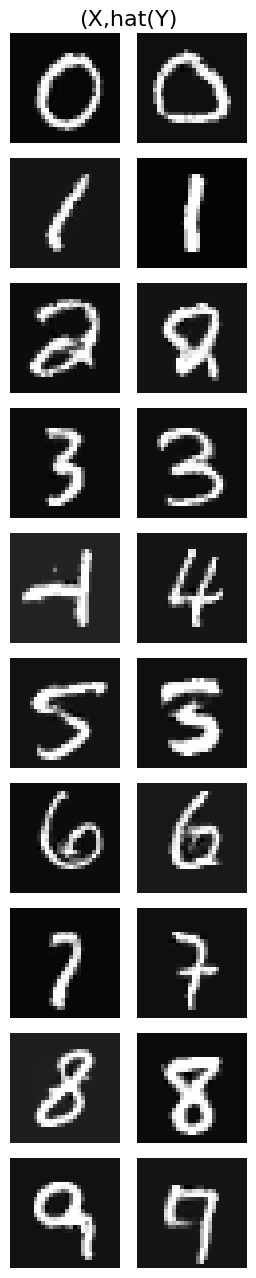

Iter: 18100, D: -0.08953, G:-0.4582
Mean L1 Loss: 0.175253, Mean L2 Loss: 0.102764
Iter: 18150, D: -0.09219, G:-0.2438
Mean L1 Loss: 0.172299, Mean L2 Loss: 0.099754
Iter: 18200, D: -0.1119, G:-0.3862
Mean L1 Loss: 0.173202, Mean L2 Loss: 0.101188
Iter: 18250, D: -0.07697, G:-0.01809
Mean L1 Loss: 0.172062, Mean L2 Loss: 0.099546
Iter: 18300, D: -0.109, G:-0.06726
Mean L1 Loss: 0.172914, Mean L2 Loss: 0.100363
Iter: 18350, D: -0.04474, G:-0.342
Mean L1 Loss: 0.173450, Mean L2 Loss: 0.101191
Iter: 18400, D: -0.09855, G:-0.4314
Mean L1 Loss: 0.174261, Mean L2 Loss: 0.101996
Iter: 18450, D: -0.07679, G:-0.2615
Mean L1 Loss: 0.172973, Mean L2 Loss: 0.100807
Iter: 18500, D: -0.08151, G:-0.3963
Mean L1 Loss: 0.172988, Mean L2 Loss: 0.100560
Iter: 18550, D: -0.09055, G:-0.0271
Mean L1 Loss: 0.172868, Mean L2 Loss: 0.100561
Iter: 18600, D: -0.1157, G:-0.6655
Mean L1 Loss: 0.171922, Mean L2 Loss: 0.100020
Iter: 18650, D: -0.08646, G:-0.5012
Mean L1 Loss: 0.171231, Mean L2 Loss: 0.099287
Iter: 1

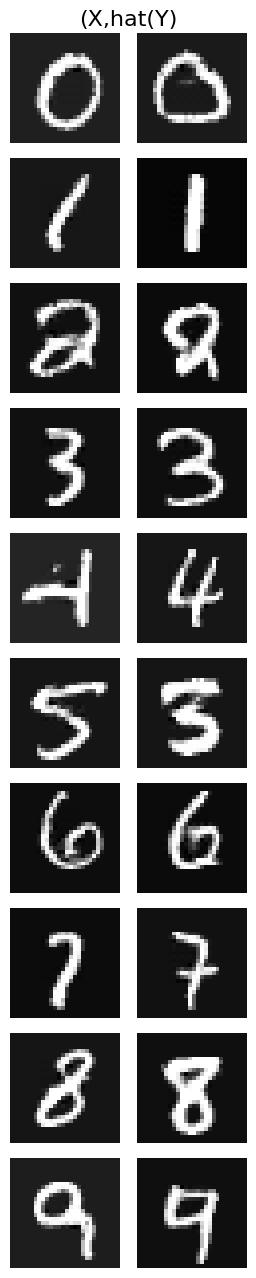

Iter: 18900, D: -0.07728, G:-0.4573
Mean L1 Loss: 0.170449, Mean L2 Loss: 0.098793
Iter: 18950, D: -0.132, G:-0.5987
Mean L1 Loss: 0.173075, Mean L2 Loss: 0.100674
Iter: 19000, D: -0.06381, G:-0.5161
Mean L1 Loss: 0.173157, Mean L2 Loss: 0.100757
Iter: 19050, D: -0.1232, G:-0.5208
Mean L1 Loss: 0.170621, Mean L2 Loss: 0.098236
################## save G model #################
Saved best model with L2: 0.0982


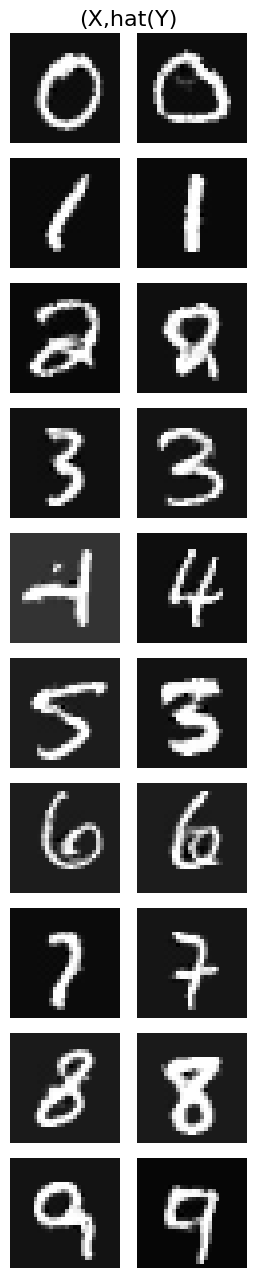

Iter: 19100, D: -0.09548, G:-0.4332
Mean L1 Loss: 0.171331, Mean L2 Loss: 0.099482
Iter: 19150, D: -0.09571, G:-0.3286
Mean L1 Loss: 0.172906, Mean L2 Loss: 0.100716
Iter: 19200, D: -0.08784, G:-0.287
Mean L1 Loss: 0.174124, Mean L2 Loss: 0.101593
Iter: 19250, D: -0.08063, G:-0.2481
Mean L1 Loss: 0.174578, Mean L2 Loss: 0.102058
Iter: 19300, D: -0.03066, G:-0.5011
Mean L1 Loss: 0.170630, Mean L2 Loss: 0.098538
Iter: 19350, D: -0.05733, G:-0.4957
Mean L1 Loss: 0.171480, Mean L2 Loss: 0.099391
Iter: 19400, D: -0.07778, G:-0.5168
Mean L1 Loss: 0.170856, Mean L2 Loss: 0.098838
Iter: 19450, D: -0.1109, G:-0.4335
Mean L1 Loss: 0.170323, Mean L2 Loss: 0.098150
################## save G model #################
Saved best model with L2: 0.0982


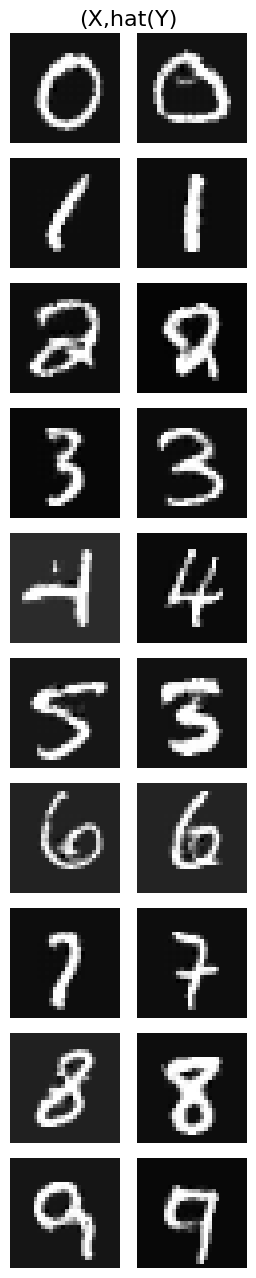

Iter: 19500, D: -0.09251, G:-0.5515
Mean L1 Loss: 0.174508, Mean L2 Loss: 0.101764
Iter: 19550, D: -0.04091, G:-0.3627
Mean L1 Loss: 0.169059, Mean L2 Loss: 0.097486
################## save G model #################
Saved best model with L2: 0.0975


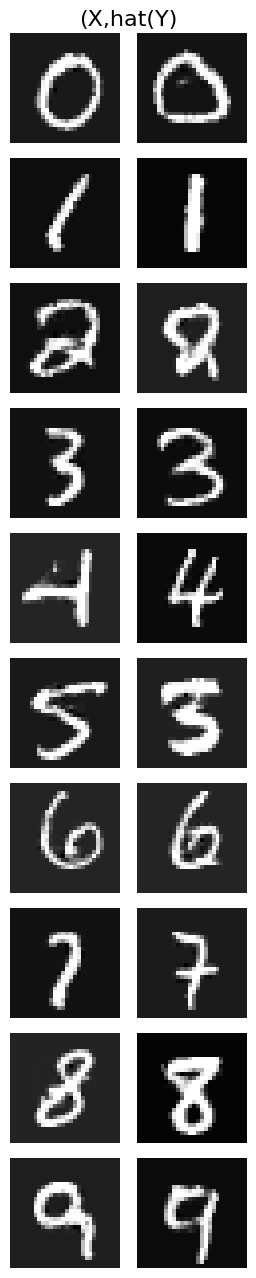

Iter: 19600, D: -0.08563, G:-0.4883
Mean L1 Loss: 0.174373, Mean L2 Loss: 0.102146
Iter: 19650, D: -0.08903, G:-0.3435
Mean L1 Loss: 0.170327, Mean L2 Loss: 0.098503
Iter: 19700, D: -0.102, G:-0.636
Mean L1 Loss: 0.171359, Mean L2 Loss: 0.099054
Iter: 19750, D: -0.09319, G:-0.7125
Mean L1 Loss: 0.171352, Mean L2 Loss: 0.099526
Iter: 19800, D: -0.0922, G:-0.5398
Mean L1 Loss: 0.172249, Mean L2 Loss: 0.099875
Iter: 19850, D: -0.09056, G:-0.4254
Mean L1 Loss: 0.172185, Mean L2 Loss: 0.099665
Iter: 19900, D: -0.0381, G:-0.527
Mean L1 Loss: 0.170657, Mean L2 Loss: 0.099080
Iter: 19950, D: -0.02738, G:-0.2684
Mean L1 Loss: 0.171666, Mean L2 Loss: 0.099618
Iter: 20000, D: -0.1069, G:-0.621
Mean L1 Loss: 0.169630, Mean L2 Loss: 0.098034
Iter: 20050, D: -0.09271, G:-0.05051
Mean L1 Loss: 0.171927, Mean L2 Loss: 0.099112
Iter: 20100, D: -0.08948, G:-0.5833
Mean L1 Loss: 0.171196, Mean L2 Loss: 0.099193
Iter: 20150, D: -0.08576, G:-0.6398
Mean L1 Loss: 0.171170, Mean L2 Loss: 0.099120
Iter: 20200

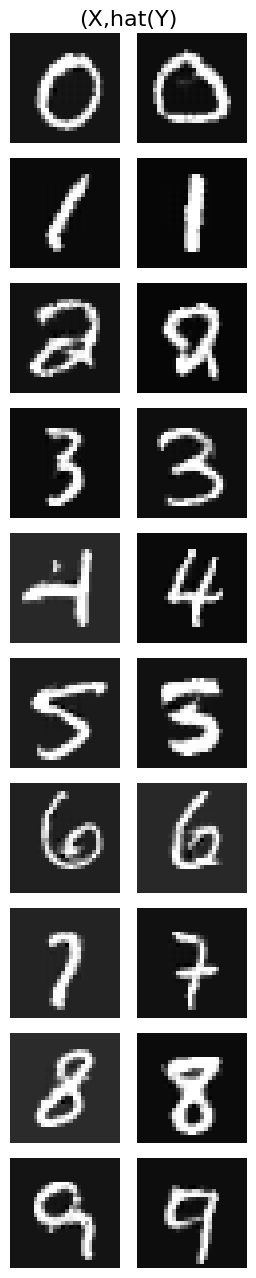

Iter: 20250, D: -0.07074, G:-0.2816
Mean L1 Loss: 0.171469, Mean L2 Loss: 0.098805
Iter: 20300, D: -0.07159, G:-0.5336
Mean L1 Loss: 0.169494, Mean L2 Loss: 0.098064
Iter: 20350, D: -0.06622, G:-0.626
Mean L1 Loss: 0.172716, Mean L2 Loss: 0.100225
Iter: 20400, D: -0.06785, G:-0.3969
Mean L1 Loss: 0.171193, Mean L2 Loss: 0.099276
Iter: 20450, D: -0.09769, G:-0.3536
Mean L1 Loss: 0.168755, Mean L2 Loss: 0.096761
################## save G model #################
Saved best model with L2: 0.0968


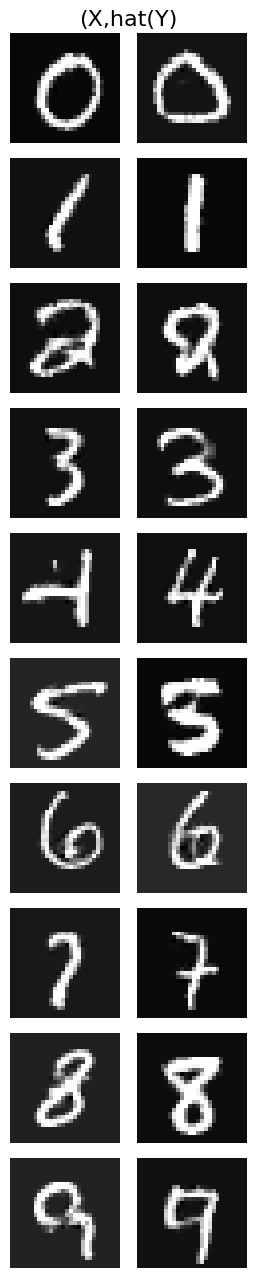

Iter: 20500, D: -0.09207, G:-0.5669
Mean L1 Loss: 0.170363, Mean L2 Loss: 0.098587
Iter: 20550, D: -0.08875, G:-0.5747
Mean L1 Loss: 0.170273, Mean L2 Loss: 0.098733
Iter: 20600, D: -0.07814, G:-0.4038
Mean L1 Loss: 0.172089, Mean L2 Loss: 0.100105
Iter: 20650, D: -0.09134, G:-0.7131
Mean L1 Loss: 0.170543, Mean L2 Loss: 0.098752
Iter: 20700, D: -0.04996, G:-0.5387
Mean L1 Loss: 0.170799, Mean L2 Loss: 0.099083
Iter: 20750, D: -0.07123, G:-0.5592
Mean L1 Loss: 0.170234, Mean L2 Loss: 0.098512
Iter: 20800, D: -0.1039, G:-0.5632
Mean L1 Loss: 0.171689, Mean L2 Loss: 0.099063
Iter: 20850, D: -0.07909, G:-0.7144
Mean L1 Loss: 0.168322, Mean L2 Loss: 0.097158
Iter: 20900, D: -0.08878, G:-0.533
Mean L1 Loss: 0.169772, Mean L2 Loss: 0.097771
Iter: 20950, D: -0.01887, G:-0.7726
Mean L1 Loss: 0.169367, Mean L2 Loss: 0.097501
Iter: 21000, D: -0.04541, G:-0.5445
Mean L1 Loss: 0.169341, Mean L2 Loss: 0.097512
Iter: 21050, D: -0.09669, G:-0.5699
Mean L1 Loss: 0.169875, Mean L2 Loss: 0.098243
Iter: 

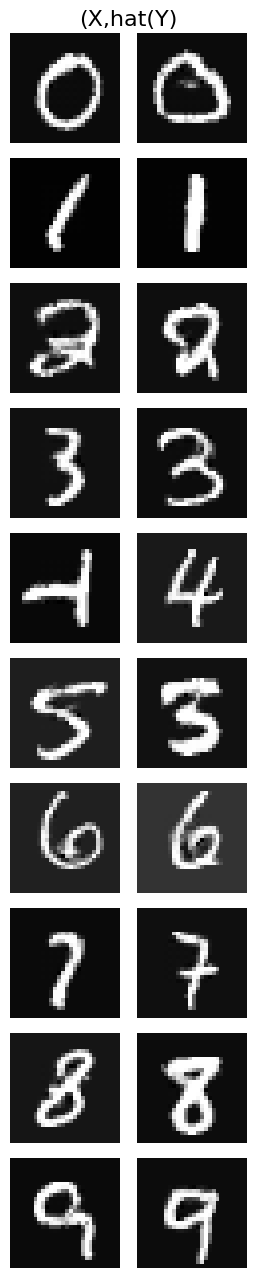

Iter: 21500, D: -0.06925, G:-0.7979
Mean L1 Loss: 0.170691, Mean L2 Loss: 0.098775
Iter: 21550, D: -0.09818, G:-0.7245
Mean L1 Loss: 0.172070, Mean L2 Loss: 0.100283
Iter: 21600, D: -0.1125, G:-0.5766
Mean L1 Loss: 0.170479, Mean L2 Loss: 0.098223
Iter: 21650, D: -0.09887, G:-0.5647
Mean L1 Loss: 0.171627, Mean L2 Loss: 0.099277
Iter: 21700, D: -0.03801, G:-0.6382
Mean L1 Loss: 0.168988, Mean L2 Loss: 0.097264
Iter: 21750, D: -0.1222, G:-0.572
Mean L1 Loss: 0.169261, Mean L2 Loss: 0.097561
Iter: 21800, D: -0.1036, G:-0.79
Mean L1 Loss: 0.168671, Mean L2 Loss: 0.096931
Iter: 21850, D: -0.08812, G:-0.918
Mean L1 Loss: 0.169836, Mean L2 Loss: 0.097743
Iter: 21900, D: -0.06435, G:-0.9591
Mean L1 Loss: 0.170007, Mean L2 Loss: 0.097921
Iter: 21950, D: -0.1448, G:-0.6247
Mean L1 Loss: 0.169427, Mean L2 Loss: 0.097287
Iter: 22000, D: -0.08618, G:-0.62
Mean L1 Loss: 0.167836, Mean L2 Loss: 0.096715
Iter: 22050, D: -0.06727, G:-0.5423
Mean L1 Loss: 0.169300, Mean L2 Loss: 0.097427
Iter: 22100, D

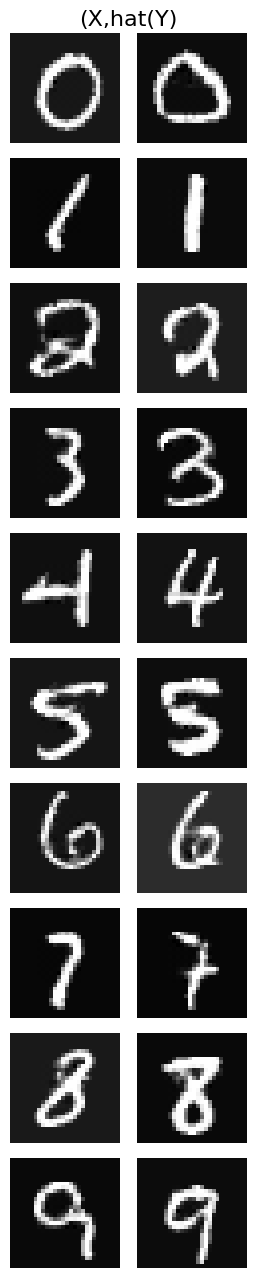

Iter: 26950, D: -0.06711, G:-0.7674
Mean L1 Loss: 0.167445, Mean L2 Loss: 0.095345
Iter: 27000, D: -0.08498, G:-0.6854
Mean L1 Loss: 0.170126, Mean L2 Loss: 0.097607
Iter: 27050, D: -0.06939, G:-1.006
Mean L1 Loss: 0.170754, Mean L2 Loss: 0.098234
Iter: 27100, D: -0.07283, G:-0.7905
Mean L1 Loss: 0.167452, Mean L2 Loss: 0.095716
Iter: 27150, D: -0.09234, G:-0.8
Mean L1 Loss: 0.169158, Mean L2 Loss: 0.096965
Iter: 27200, D: -0.06458, G:-0.749
Mean L1 Loss: 0.168807, Mean L2 Loss: 0.096665
Iter: 27250, D: -0.02714, G:-0.8035
Mean L1 Loss: 0.167243, Mean L2 Loss: 0.095181
Iter: 27300, D: -0.07476, G:-0.7466
Mean L1 Loss: 0.168849, Mean L2 Loss: 0.096484
Iter: 27350, D: -0.1014, G:-0.6377
Mean L1 Loss: 0.169170, Mean L2 Loss: 0.096941
Iter: 27400, D: -0.06275, G:-0.5015
Mean L1 Loss: 0.168611, Mean L2 Loss: 0.095911
Iter: 27450, D: -0.07236, G:-0.5475
Mean L1 Loss: 0.167605, Mean L2 Loss: 0.095353
Iter: 27500, D: -0.08861, G:-0.7135
Mean L1 Loss: 0.165520, Mean L2 Loss: 0.094009
##########

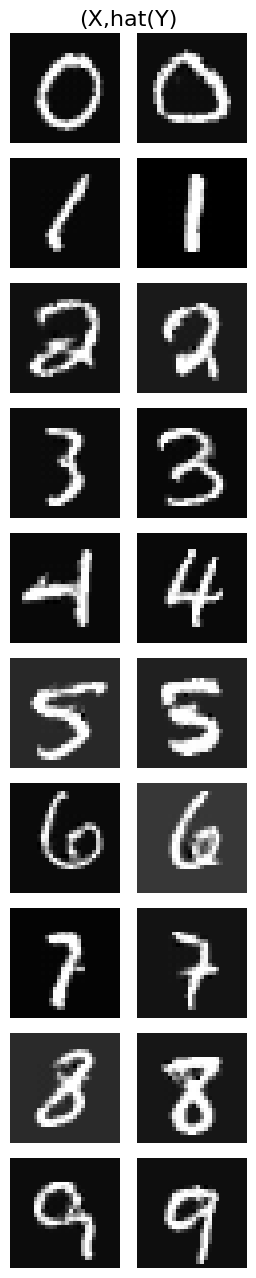

Iter: 27550, D: -0.09067, G:-0.9005
Mean L1 Loss: 0.169885, Mean L2 Loss: 0.097538
Iter: 27600, D: -0.09081, G:-0.6846
Mean L1 Loss: 0.166843, Mean L2 Loss: 0.094777
Iter: 27650, D: -0.1002, G:-0.8977
Mean L1 Loss: 0.168074, Mean L2 Loss: 0.095863
Iter: 27700, D: -0.08357, G:-1.017
Mean L1 Loss: 0.171116, Mean L2 Loss: 0.098198
Iter: 27750, D: -0.09022, G:-0.8951
Mean L1 Loss: 0.167061, Mean L2 Loss: 0.095357
Iter: 27800, D: -0.0822, G:-0.7673
Mean L1 Loss: 0.168586, Mean L2 Loss: 0.096786
Iter: 27850, D: -0.0593, G:-0.6729
Mean L1 Loss: 0.167554, Mean L2 Loss: 0.095459
Iter: 27900, D: -0.06023, G:-0.4486
Mean L1 Loss: 0.167503, Mean L2 Loss: 0.095704
Iter: 27950, D: -0.04923, G:-0.7634
Mean L1 Loss: 0.167084, Mean L2 Loss: 0.095008
Iter: 28000, D: -0.0767, G:-0.9667
Mean L1 Loss: 0.167129, Mean L2 Loss: 0.095042
Iter: 28050, D: -0.08395, G:-0.9286
Mean L1 Loss: 0.167293, Mean L2 Loss: 0.095457
Iter: 28100, D: -0.07038, G:-0.8688
Mean L1 Loss: 0.166597, Mean L2 Loss: 0.094831
Iter: 281

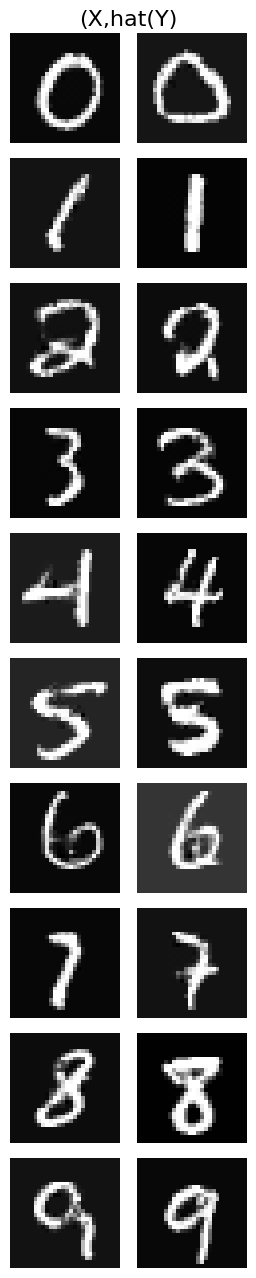

Iter: 31150, D: -0.05431, G:-0.7713
Mean L1 Loss: 0.166466, Mean L2 Loss: 0.093936
Iter: 31200, D: -0.1109, G:-1.207
Mean L1 Loss: 0.167999, Mean L2 Loss: 0.095887
Iter: 31250, D: -0.03333, G:-0.9655
Mean L1 Loss: 0.166799, Mean L2 Loss: 0.094583
Iter: 31300, D: -0.07254, G:-0.719
Mean L1 Loss: 0.168800, Mean L2 Loss: 0.095853
Iter: 31350, D: -0.07887, G:-0.7857
Mean L1 Loss: 0.167035, Mean L2 Loss: 0.094882
Iter: 31400, D: -0.09846, G:-0.8137
Mean L1 Loss: 0.167869, Mean L2 Loss: 0.095679
Iter: 31450, D: -0.07944, G:-0.8196
Mean L1 Loss: 0.168727, Mean L2 Loss: 0.096346
Iter: 31500, D: -0.1189, G:-0.807
Mean L1 Loss: 0.166136, Mean L2 Loss: 0.094178
Iter: 31550, D: -0.06896, G:-0.8359
Mean L1 Loss: 0.166245, Mean L2 Loss: 0.093968
Iter: 31600, D: -0.1076, G:-0.8397
Mean L1 Loss: 0.169638, Mean L2 Loss: 0.097292
Iter: 31650, D: -0.08654, G:-1.034
Mean L1 Loss: 0.167567, Mean L2 Loss: 0.095237
Iter: 31700, D: -0.08622, G:-1.011
Mean L1 Loss: 0.168723, Mean L2 Loss: 0.095995
Iter: 31750,

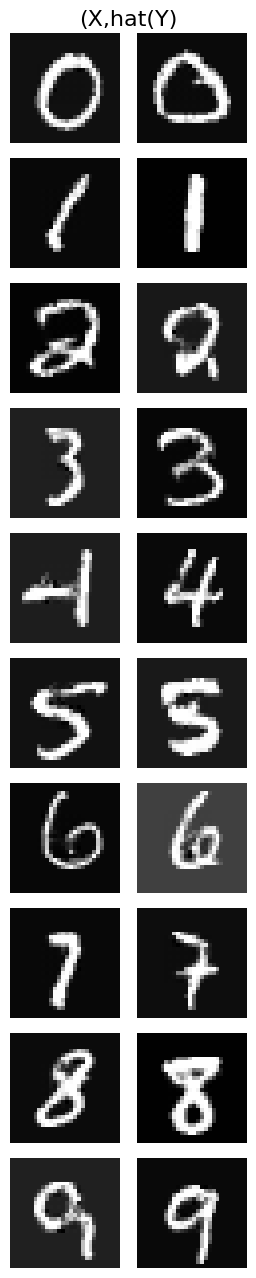

Iter: 32100, D: -0.08605, G:-0.4961
Mean L1 Loss: 0.165997, Mean L2 Loss: 0.093751
################## save G model #################
Saved best model with L2: 0.0938


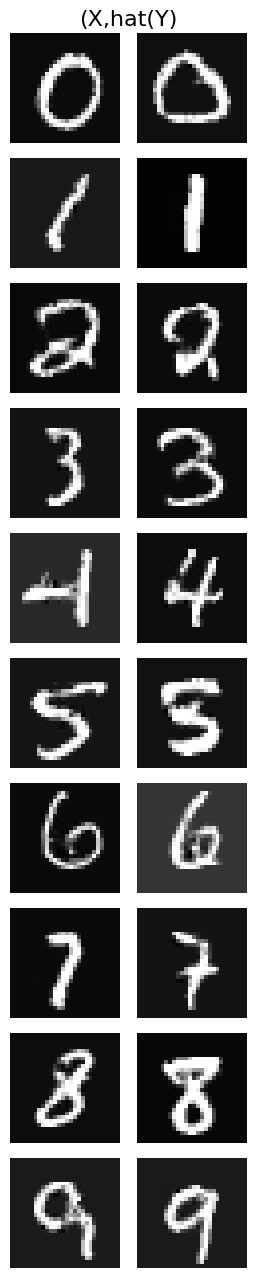

Iter: 32150, D: -0.05098, G:-0.629
Mean L1 Loss: 0.167427, Mean L2 Loss: 0.095327
Iter: 32200, D: -0.0579, G:-0.7035
Mean L1 Loss: 0.168287, Mean L2 Loss: 0.095209
Iter: 32250, D: -0.061, G:-0.6981
Mean L1 Loss: 0.166866, Mean L2 Loss: 0.094502
Iter: 32300, D: -0.09638, G:-0.8554
Mean L1 Loss: 0.166881, Mean L2 Loss: 0.094786
Iter: 32350, D: -0.07874, G:-0.7909
Mean L1 Loss: 0.170411, Mean L2 Loss: 0.097481
Iter: 32400, D: -0.06439, G:-0.8896
Mean L1 Loss: 0.167037, Mean L2 Loss: 0.094651
Iter: 32450, D: -0.05137, G:-1.107
Mean L1 Loss: 0.168445, Mean L2 Loss: 0.095949
Iter: 32500, D: -0.08282, G:-0.9223
Mean L1 Loss: 0.166806, Mean L2 Loss: 0.094423
Iter: 32550, D: -0.1115, G:-0.8945
Mean L1 Loss: 0.166518, Mean L2 Loss: 0.094423
Iter: 32600, D: -0.1263, G:-0.9839
Mean L1 Loss: 0.165237, Mean L2 Loss: 0.093650
################## save G model #################
Saved best model with L2: 0.0937


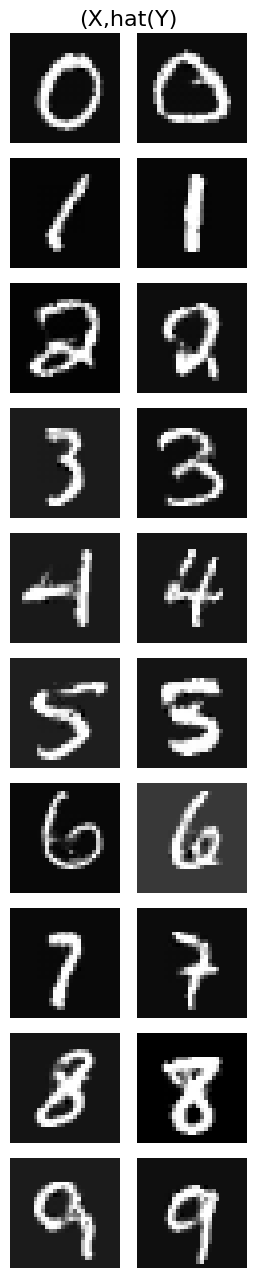

Iter: 32650, D: -0.08197, G:-0.7303
Mean L1 Loss: 0.167382, Mean L2 Loss: 0.094886
Iter: 32700, D: -0.08612, G:-0.8008
Mean L1 Loss: 0.166869, Mean L2 Loss: 0.094281
Iter: 32750, D: -0.07136, G:-0.8843
Mean L1 Loss: 0.169017, Mean L2 Loss: 0.096281
Iter: 32800, D: -0.06462, G:-0.542
Mean L1 Loss: 0.168552, Mean L2 Loss: 0.095641
Iter: 32850, D: -0.07634, G:-0.8262
Mean L1 Loss: 0.168696, Mean L2 Loss: 0.096140
Iter: 32900, D: -0.03816, G:-0.9682
Mean L1 Loss: 0.168726, Mean L2 Loss: 0.096036
Iter: 32950, D: -0.02502, G:-0.9231
Mean L1 Loss: 0.167739, Mean L2 Loss: 0.094808
Iter: 33000, D: -0.09139, G:-0.5656
Mean L1 Loss: 0.166596, Mean L2 Loss: 0.094168
Iter: 33050, D: -0.04847, G:-0.7195
Mean L1 Loss: 0.166629, Mean L2 Loss: 0.094425
Iter: 33100, D: -0.0616, G:-1.126
Mean L1 Loss: 0.167186, Mean L2 Loss: 0.095030
Iter: 33150, D: -0.05825, G:-0.4714
Mean L1 Loss: 0.167549, Mean L2 Loss: 0.095010
Iter: 33200, D: -0.08077, G:-0.6847
Mean L1 Loss: 0.166071, Mean L2 Loss: 0.094113
Iter: 3

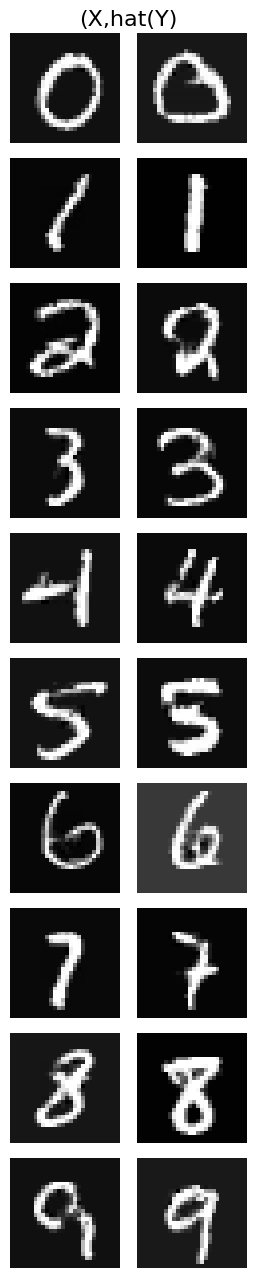

Iter: 34100, D: -0.09836, G:-0.8482
Mean L1 Loss: 0.167502, Mean L2 Loss: 0.095028
Iter: 34150, D: -0.03738, G:-0.9603
Mean L1 Loss: 0.166488, Mean L2 Loss: 0.094273
Iter: 34200, D: -0.0904, G:-1.03
Mean L1 Loss: 0.167732, Mean L2 Loss: 0.095228
Iter: 34250, D: -0.0452, G:-0.925
Mean L1 Loss: 0.167465, Mean L2 Loss: 0.094750
Iter: 34300, D: -0.05747, G:-0.9942
Mean L1 Loss: 0.166600, Mean L2 Loss: 0.094245
Iter: 34350, D: -0.1109, G:-0.8098
Mean L1 Loss: 0.166209, Mean L2 Loss: 0.093761
Iter: 34400, D: -0.09926, G:-0.814
Mean L1 Loss: 0.166911, Mean L2 Loss: 0.094608
Iter: 34450, D: -0.07467, G:-0.8155
Mean L1 Loss: 0.167819, Mean L2 Loss: 0.095399
Iter: 34500, D: -0.06121, G:-1.04
Mean L1 Loss: 0.167424, Mean L2 Loss: 0.095223
Iter: 34550, D: -0.07258, G:-0.8797
Mean L1 Loss: 0.166292, Mean L2 Loss: 0.094419
Iter: 34600, D: -0.07325, G:-0.775
Mean L1 Loss: 0.168854, Mean L2 Loss: 0.095970
Iter: 34650, D: -0.08145, G:-0.9121
Mean L1 Loss: 0.167549, Mean L2 Loss: 0.094941
Iter: 34700, D

In [12]:
trained_G, trained_D = train_WGR_image(D=D_net,G=G_net, D_solver=D_solver,G_solver=G_solver,Xdim=args.Xdim, Ydim=args.Ydim, 
                                       noise_dim=args.noise_dim, loader_data=train_loader,  loader_val=val_loader, 
                                       batch_size = args.train_batch, eg_x =eg_x,  eg_label=eg_label, 
                                       selected_indices=selected_indices, lambda_w=0.8, lambda_l=0.2, num_epochs=400)    

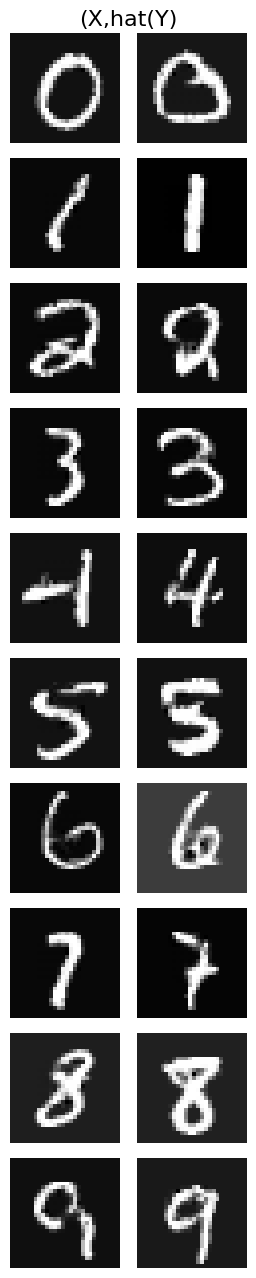

In [13]:
eg_eta =  sample_noise(args.train_batch, dim=args.noise_dim ).to(device)
g_exam_input = torch.cat([eg_x.view(args.train_batch, args.Xdim), eg_eta], dim=1)
recon_y = trained_G(g_exam_input).view(args.train_batch,1,12,12)
                        
recon_x = eg_x.clone()
recon_x[selected_indices,:,7:19,7:19] = recon_y[selected_indices,:,:,:].detach()
visualize_digits( images=recon_x[selected_indices] , labels = eg_label[selected_indices], figsize=(3, 13), title='(X,hat(Y)')